In [1]:
import warnings
import netCDF4
import cmocean.cm as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmovie import Movie
import matplotlib.path as mpath
import numpy as np
import xarray as xr

from dask.distributed import Client
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import cosima_cookbook as cc


warnings.filterwarnings("ignore") # Suppress warnings for these docs

In [2]:
db = 'local_cc_scratch_Ryan_data.db'
session = cc.database.create_session(db)

experiment = '025deg_jra55_iaf_cycle6_online_mlt'

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

<Client: 'tcp://127.0.0.1:45313' processes=21 threads=21, memory=765.00 GiB>

In [4]:
import cosima_cookbook as cc
# Input variable as 'salt' for salinity, 'temp' for temperature
temp = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='temp', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='1957-12-31 00:00:00', 
                          end_time='2023-11-30 00:00:00')

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 108. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12

In [5]:
temp_depth = temp - 273.15
temp_depth = temp_depth.sel(yt_ocean = slice(-90,-40)).sel(st_ocean = slice(0,3000)).\
                        sel(time = slice('1981','2024'))## Restrict to Southern Ocean
print(temp_depth)

<xarray.DataArray 'temp' (time: 516, st_ocean: 39, yt_ocean: 323, xt_ocean: 1440)> Size: 37GB
dask.array<getitem, shape=(516, 39, 323, 1440), dtype=float32, chunksize=(1, 25, 108, 120), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 3kB -81.08 -80.97 -80.87 ... -40.32 -40.13
  * time      (time) datetime64[ns] 4kB 1981-01-14T12:00:00 ... 2023-12-14T12...
  * st_ocean  (st_ocean) float64 312B 1.152 3.649 6.565 ... 2.654e+03 2.864e+03


In [6]:
def calculate_temp_anomaly(data):
    """
    Calculates monthly temperature anomalies based on a 30-year climatology,
    applies a rolling mean smoothing to the climatology, and returns both smoothed climatology and unsmoothed anomalies.
    """
    baseline_period = data.sel(time=slice("1981-12-30T12:00:00", "2011-12-30T12:00:00"))

    clim_data = baseline_period.groupby("time.season").mean("time")
    print("Climatology Data Shape:", clim_data.shape)

    # Calculating anomalies by subtracting the smoothed climatology from the original data
    temp_anomalies = data.groupby("time.season") - clim_data
    print("Anomalies Data Shape:", temp_anomalies.shape)

    return clim_data, temp_anomalies

smoothed_clim_data, temp_anomalies = calculate_temp_anomaly(temp_depth)

temp_anomalies.groupby('time.season').mean('time')

Climatology Data Shape: (4, 39, 323, 1440)
Anomalies Data Shape: (516, 39, 323, 1440)


<xarray.DataArray 'temp' (season: 4, st_ocean: 39, yt_ocean: 323, xt_ocean: 1440)> Size: 290MB
dask.array<transpose, shape=(4, 39, 323, 1440), dtype=float32, chunksize=(1, 25, 108, 120), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 3kB -81.08 -80.97 -80.87 ... -40.32 -40.13
  * st_ocean  (st_ocean) float64 312B 1.152 3.649 6.565 ... 2.654e+03 2.864e+03
  * season    (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

In [7]:
seasonal_clim, temp_anomalies = calculate_temp_anomaly(temp_depth)
print(temp_anomalies)

Climatology Data Shape: (4, 39, 323, 1440)
Anomalies Data Shape: (516, 39, 323, 1440)
<xarray.DataArray 'temp' (time: 516, st_ocean: 39, yt_ocean: 323, xt_ocean: 1440)> Size: 37GB
dask.array<sub, shape=(516, 39, 323, 1440), dtype=float32, chunksize=(1, 25, 108, 120), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 3kB -81.08 -80.97 -80.87 ... -40.32 -40.13
  * time      (time) datetime64[ns] 4kB 1981-01-14T12:00:00 ... 2023-12-14T12...
  * st_ocean  (st_ocean) float64 312B 1.152 3.649 6.565 ... 2.654e+03 2.864e+03
    season    (time) object 4kB 'DJF' 'DJF' 'MAM' 'MAM' ... 'SON' 'SON' 'DJF'


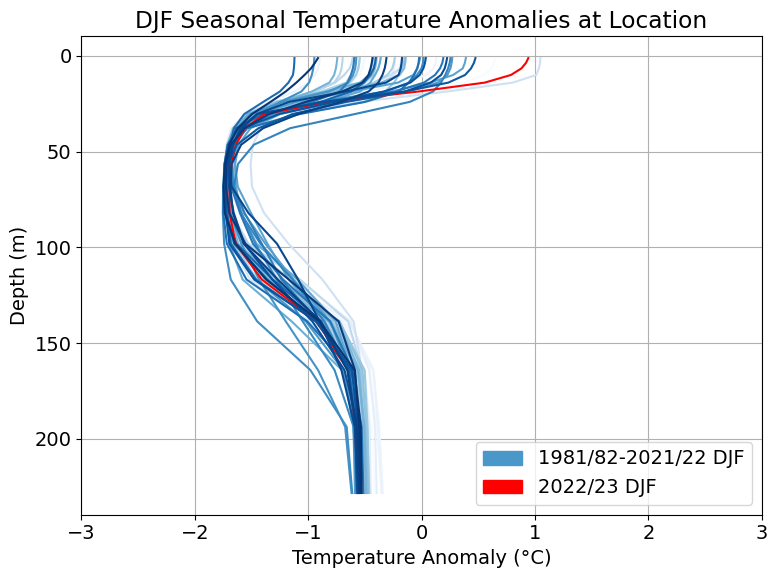

In [8]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Select location and average spatially
location_anom = temp_depth.sel(
    yt_ocean=slice(-69, -63),
    xt_ocean=slice(-15, 10)
).mean(dim=['yt_ocean', 'xt_ocean'])

time = location_anom["time"]

location_anom = location_anom.assign_coords(
    year=time.dt.year,
    month=time.dt.month,
    season=time.dt.season
)

# Dealing with December of Summer one year being grouped with it for the next year
djf_year = xr.where(
    (location_anom.month == 12),
    location_anom.year + 1,
    location_anom.year
)

location_anom = location_anom.assign_coords(djf_year=djf_year)

# Pick out DJF anomalies
is_djf = location_anom.season == "DJF"
djf_data = location_anom.sel(time=is_djf)

# Building labels
year_str = djf_data["djf_year"].values.astype(str)
season_str = djf_data["season"].values.astype(str)
year_season_labels = np.char.add(np.char.add(year_str, "_"), season_str)
djf_data = djf_data.assign_coords(year_season=("time", year_season_labels))

seasonal_profiles = djf_data.groupby("year_season").mean(dim="time")


fig, ax = plt.subplots(figsize=(8,6))

for i, ys in enumerate(sorted(seasonal_profiles.year_season.values)):
    profile = seasonal_profiles.sel(year_season=ys)
    
    if "2017_DJF" in ys:
        color = 'red'
    else:
        color = plt.cm.Blues(i / len(seasonal_profiles.year_season))
    ax.plot(profile.values, profile.st_ocean, color=color)

ax.invert_yaxis()
#ax.set_xlabel("Salinity Anomaly (psu)")
ax.set_xlabel("Temperature Anomaly (°C)")
ax.set_ylabel("Depth (m)")
ax.set_title("DJF Seasonal Temperature Anomalies at Location")
#ax.set_title("DJF Seasonal Salinity Anomalies at Location")

# Create legend
blue_patch = mpatches.Patch(color=plt.cm.Blues(0.6), label='1981/82-2021/22 DJF')
red_patch = mpatches.Patch(color='red', label='2022/23 DJF')
ax.legend(handles=[blue_patch, red_patch], loc='best')

ax.grid(True)
ax.set_xlim(-3., 3.) 

plt.tight_layout()
plt.show()

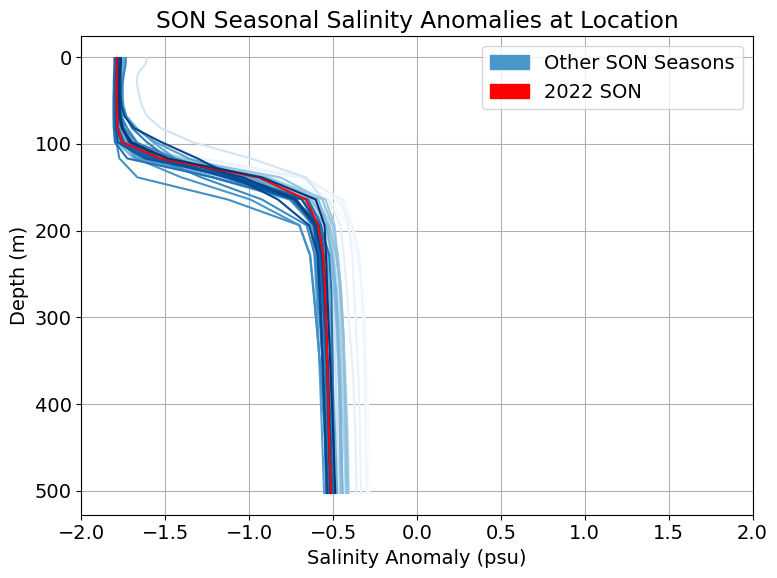

In [8]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Select location and average spatially
location_anom = temp_depth.sel(
    yt_ocean=slice(-69, -63),
    xt_ocean=slice(-15, 10)
).mean(dim=['yt_ocean', 'xt_ocean'])

time = location_anom["time"]

# Add year, month, and season
location_anom = location_anom.assign_coords(
    year=time.dt.year,
    month=time.dt.month,
    season=time.dt.season
)

# Filter to just SON
is_son = location_anom.season == "SON"
son_data = location_anom.sel(time=is_son)

# Build year_season labels (no year adjustment needed for SON)
year_str = son_data["year"].values.astype(str)
season_str = son_data["season"].values.astype(str)
year_season_labels = np.char.add(np.char.add(year_str, "_"), season_str)
son_data = son_data.assign_coords(year_season=("time", year_season_labels))

# Group and average
seasonal_profiles = son_data.groupby("year_season").mean(dim="time")

# Plotting
fig, ax = plt.subplots(figsize=(8,6))

for i, ys in enumerate(sorted(seasonal_profiles.year_season.values)):
    profile = seasonal_profiles.sel(year_season=ys)
    
    if "2022_SON" in ys:
        color = 'red'
    else:
        color = plt.cm.Blues(i / len(seasonal_profiles.year_season))
    ax.plot(profile.values, profile.st_ocean, color=color)

ax.invert_yaxis()
ax.set_xlabel("Salinity Anomaly (psu)")
ax.set_ylabel("Depth (m)")
ax.set_title("SON Seasonal Salinity Anomalies at Location")

# Legend
blue_patch = mpatches.Patch(color=plt.cm.Blues(0.6), label='Other SON Seasons')
red_patch = mpatches.Patch(color='red', label='2022 SON')
ax.legend(handles=[blue_patch, red_patch], loc='best')

ax.grid(True)
ax.set_xlim(-2, 2.)

plt.tight_layout()
plt.show()


## Redo with Months

In [7]:
def calculate_temp_anomaly(data):
    """
    Calculates monthly temperature anomalies based on a 30-year climatology,
    applies a rolling mean smoothing to the climatology, and returns both smoothed climatology and unsmoothed anomalies.
    """
    baseline_period = data.sel(time=slice("1981-12-30T12:00:00", "2011-12-30T12:00:00"))

    clim_data = baseline_period.groupby("time.month").mean("time")
    print("Climatology Data Shape:", clim_data.shape)

    # Calculating anomalies by subtracting the smoothed climatology from the original data
    temp_anomalies = data.groupby("time.month") - clim_data
    print("Anomalies Data Shape:", temp_anomalies.shape)

    return clim_data, temp_anomalies

clim_data, temp_anomalies = calculate_temp_anomaly(temp_depth)

# temp_anomalies = temp_anomalies.groupby('time.month').mean('time')
temp_anomalies

Climatology Data Shape: (12, 19, 323, 1440)
Anomalies Data Shape: (516, 19, 323, 1440)


<xarray.DataArray 'temp' (time: 516, st_ocean: 19, yt_ocean: 323, xt_ocean: 1440)> Size: 18GB
dask.array<sub, shape=(516, 19, 323, 1440), dtype=float32, chunksize=(1, 19, 108, 120), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 3kB -81.08 -80.97 -80.87 ... -40.32 -40.13
  * time      (time) datetime64[ns] 4kB 1981-01-14T12:00:00 ... 2023-12-14T12...
  * st_ocean  (st_ocean) float64 152B 1.152 3.649 6.565 ... 164.0 193.7 228.2
    month     (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

<xarray.DataArray 'temp' (year_month: 43, st_ocean: 19)> Size: 3kB
dask.array<transpose, shape=(43, 19), dtype=float32, chunksize=(1, 19), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean    (st_ocean) float64 152B 1.152 3.649 6.565 ... 164.0 193.7 228.2
  * year_month  (year_month) object 344B '1981_05' '1982_05' ... '2023_05'
['1981_05' '1982_05' '1983_05' '1984_05' '1985_05' '1986_05' '1987_05'
 '1988_05' '1989_05' '1990_05' '1991_05' '1992_05' '1993_05' '1994_05'
 '1995_05' '1996_05' '1997_05' '1998_05' '1999_05' '2000_05' '2001_05'
 '2002_05' '2003_05' '2004_05' '2005_05' '2006_05' '2007_05' '2008_05'
 '2009_05' '2010_05' '2011_05' '2012_05' '2013_05' '2014_05' '2015_05'
 '2016_05' '2017_05' '2018_05' '2019_05' '2020_05' '2021_05' '2022_05'
 '2023_05']


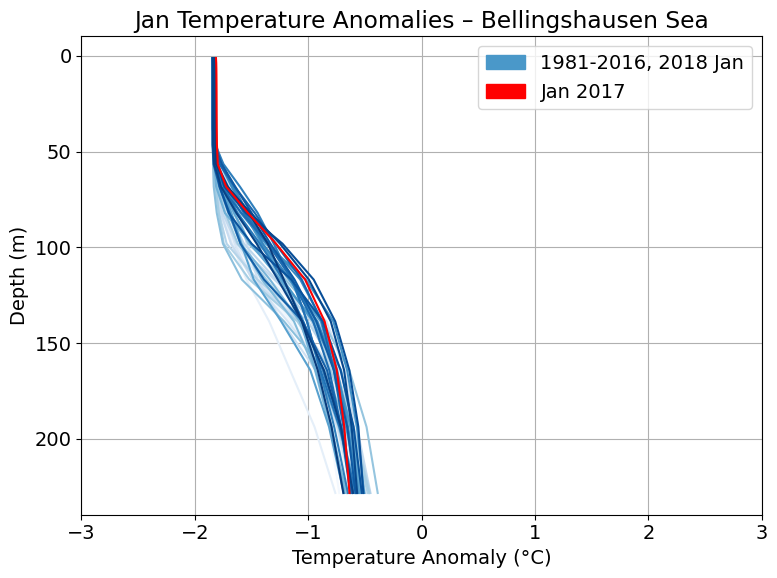

In [11]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

location_anom = temp_depth.\
                sel(yt_ocean=slice(-73,-69)).sel(xt_ocean=slice(-190,-170)).\
                mean(dim=['yt_ocean', 'xt_ocean'])
#slice(-145,-140, )
#.mean(dim=['yt_ocean', 'xt_ocean'])

time = location_anom["time"]

# Add year and month
location_anom = location_anom.assign_coords(
    year=time.dt.year,
    month=time.dt.month
)

target_month = 5  # September
monthly_data = location_anom.sel(time=location_anom.month == target_month)

# Build year_month labels
year_str = monthly_data["year"].values.astype(str)
month_str = np.array([f"{target_month:02d}"] * len(year_str))  # force zero-padded format
year_month_labels = np.char.add(np.char.add(year_str, "_"), month_str)
monthly_data = monthly_data.assign_coords(year_month=("time", year_month_labels))

# Group and average
monthly_profiles = monthly_data.groupby("year_month").mean(dim="time")

print(monthly_profiles)
print(monthly_profiles.year_month.values)


# Plotting
fig, ax = plt.subplots(figsize=(8,6))

for i, ym in enumerate(sorted(monthly_profiles.year_month.values)):
    profile = monthly_profiles.sel(year_month=ym)
    
    if "2023_05" in ym:
        color = 'red'
    else:
        color = plt.cm.Blues(i / len(monthly_profiles.year_month))
    ax.plot(profile.values, profile.st_ocean, color=color)

ax.invert_yaxis()
# ax.set_xlabel("Salinty Anomaly (psu)")
ax.set_xlabel("Temperature Anomaly (°C)")
ax.set_ylabel("Depth (m)")
#ax.set_title("Feb Salinity Anomalies at Location")
ax.set_title("Jan Temperature Anomalies – Bellingshausen Sea")

# Legend
blue_patch = mpatches.Patch(color=plt.cm.Blues(0.6), label='1981-2016, 2018 Jan')
red_patch = mpatches.Patch(color='red', label='Jan 2017')
ax.legend(handles=[blue_patch, red_patch], loc='best')

ax.grid(True)
ax.set_xlim(-3.,3.)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import numpy as np

# --- Styling ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
})

# Months from December to May
months = [11, 12, 1, 2, 3, 4, 5]
month_names = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']

# Select spatially averaged temperature anomaly
location_anom = temp_anomalies.sel(yt_ocean=slice(-70, -63)).sel(xt_ocean=slice(-15, 10)).mean(dim=['yt_ocean', 'xt_ocean'])
time = location_anom["time"]

# Add year and month coordinates
location_anom = location_anom.assign_coords(
    year=time.dt.year,
    month=time.dt.month
)

# Depth coordinate for plotting
depth = location_anom.st_ocean

fig, axes = plt.subplots(len(months), 1, figsize=(8, 4 * len(months)), sharex=True, sharey=True)

for ax, month, month_name in zip(axes, months, month_names):
    monthly_data = location_anom.sel(time=location_anom.month == month)

    # Build year_month labels
    year_str = monthly_data["year"].values.astype(str)
    month_str = np.array([f"{month:02d}"] * len(year_str))
    year_month_labels = np.char.add(np.char.add(year_str, "_"), month_str)
    monthly_data = monthly_data.assign_coords(year_month=("time", year_month_labels))

    years_months_sorted = sorted(monthly_data.year_month.values)
    cmap = cm.Blues

    for i, ym in enumerate(years_months_sorted):
        profile = monthly_data.sel(time=monthly_data.year_month == ym)
        prof_vals = profile.values[0]

        highlight_year = '2017' if month != 12 else '2016'
        if ym.startswith(highlight_year):
            color = 'red'
            label = f"{month_name} {highlight_year}"
        else:
            color = cmap(i / len(years_months_sorted))
            label = None

        ax.plot(prof_vals, depth, color=color, alpha=0.8, label=label)

    ax.set_xlim(-3.0, 3.0)
    ax.set_ylim(depth.max(), depth.min())  # <-- THIS fixes the y-axis orientation
    ax.set_ylabel("Depth (m)")
    ax.set_title(f"{month_name} Temperature – Weddell Sea")

    # Major and minor ticks for x-axis
    major_locator = ticker.MultipleLocator(0.5)
    minor_locator = ticker.MultipleLocator(0.25)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

    ax.grid(True, linestyle='--', alpha=0.6)

# X-axis label only on bottom subplot
axes[-1].set_xlabel("Temperature (°C)")

# Legend on the last subplot
blue_patch = mpatches.Patch(color=cmap(0.6), label='Other Years')
red_patch = mpatches.Patch(color='red', label='2017 (Dec: 2016)')
axes[-1].legend(handles=[blue_patch, red_patch], loc='best', frameon=False, fontsize=14)

plt.tight_layout()
plt.show()


2025-09-04 16:56:57,681 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('open_dataset-f0a92b72-45d2-452c-bf4e-fa045a699d78')" coro=<Worker.execute() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/worker_state_machine.py:3606>> ended with CancelledError
2025-09-04 16:56:57,687 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('open_dataset-e13be1f9-f2e6-412e-b863-59fd9408d7e0')" coro=<Worker.execute() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/worker_state_machine.py:3606>> ended with CancelledError
2025-09-04 16:56:57,688 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/comm/tcp

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# --- Styling ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
})

# Months from November to May
months = [11, 12, 1, 2, 3, 4, 5]
month_names = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']

# Spatially averaged temperature anomalies
location_anom = temp_depth.sel(yt_ocean=slice(-72, -68)) \
                              .sel(xt_ocean=slice(-190, -180)) \
                              .mean(dim=['yt_ocean', 'xt_ocean'])
time = location_anom["time"]

# Add year and month coordinates
location_anom = location_anom.assign_coords(
    year=time.dt.year,
    month=time.dt.month
)

# Depth coordinate for plotting
depth = location_anom.st_ocean

fig, axes = plt.subplots(len(months), 1, figsize=(8, 3.5 * len(months)), sharex=True)

# Colors
faint_color = 'lightgray'       # faint individual profiles
argo_color = '#40E0D0'          # turquoise, same as Argo profiler

for ax, month, month_name in zip(axes, months, month_names):
    # Pick year based on month
    target_year = 2016 if month in (11, 12) else 2017

    # Boolean mask for target year & month
    mask = (location_anom.year == target_year) & (location_anom.month == month)
    profiles = location_anom.where(mask, drop=True)

    num_profiles = profiles.time.size

    if num_profiles == 0:
        ax.text(0.5, 0.5, 'No profiles', transform=ax.transAxes,
                ha='center', va='center', fontsize=14, color='gray')
        continue

    # Plot all individual profiles faintly
    for i in range(num_profiles):
        ax.plot(profiles.values[i], depth, color=faint_color, alpha=0.2)

    # Plot mean profile in Argo color
    mean_profile = np.nanmean(profiles.values, axis=0)
    ax.plot(mean_profile, depth, color=argo_color, linewidth=2.5,
            label=f"Mean ({num_profiles})")

    # Axes settings
    ax.set_ylim(depth.max(), depth.min())
    ax.set_xlim(-2.0, 3.0)

    # X-axis ticks every 0.25°C
    major_locator = ticker.MultipleLocator(0.5)
    minor_locator = ticker.MultipleLocator(0.25)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    # Labels & title
    ax.set_ylabel("Depth (m)")
    ax.set_title(f"{month_name} Temperature – Weddell Sea (Monthly Averaged)")

    ax.grid(True, linestyle='--', alpha=0.6)

axes[-1].set_xlabel("Temperature (°C)")

plt.tight_layout()
plt.show()



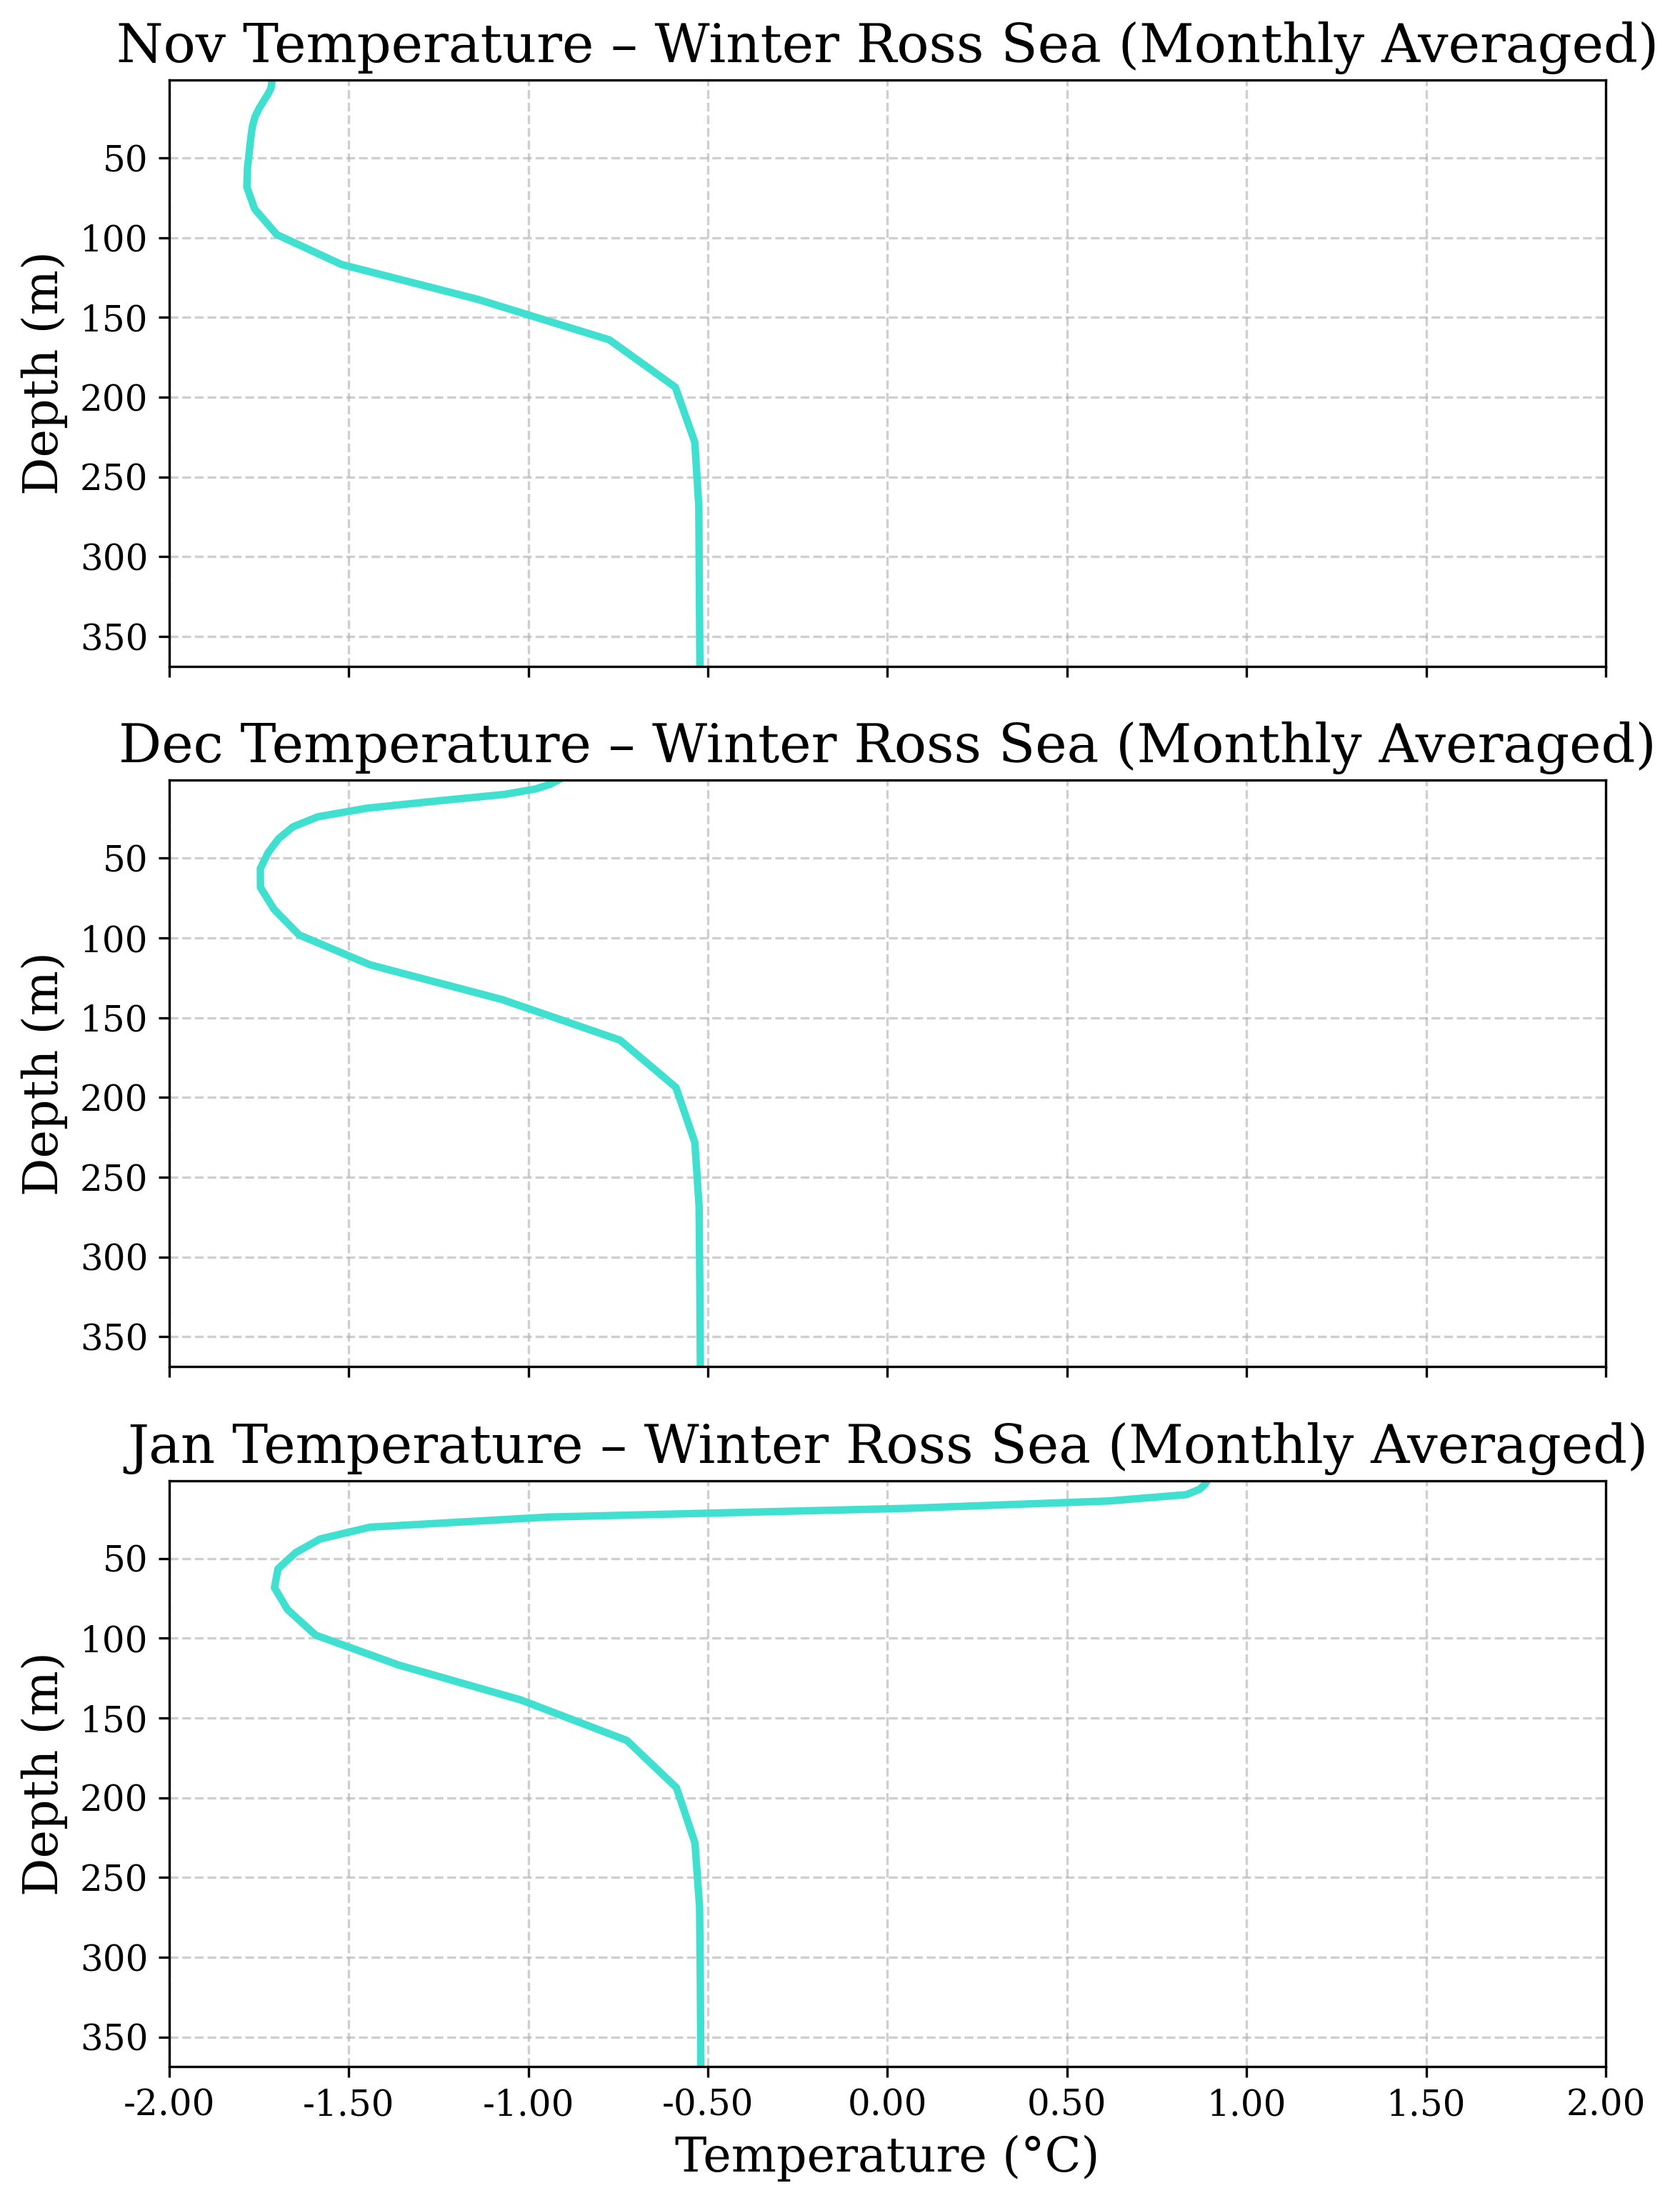

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

# --- Styling ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
})

# Months from November to May
months = [11, 12, 1]
month_names = ['Nov', 'Dec', 'Jan']

# months = [3, 4, 5, 6, 7, 8, 9]
# month_names = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

# Spatially averaged temperature anomalies
location_anom = temp_depth.sel(yt_ocean=slice(-68,-63)) \
                              .sel(xt_ocean=slice(-20, 10)) \
                              .mean(dim=['yt_ocean', 'xt_ocean']).sel(st_ocean = slice(0,400))
time = location_anom["time"]

# Add year and month coordinates
location_anom = location_anom.assign_coords(
    year=time.dt.year,
    month=time.dt.month
)

# Depth coordinate for plotting
depth = location_anom.st_ocean

fig, axes = plt.subplots(len(months), 1, figsize=(8, 3.5 * len(months)), sharex=True)

# Colors
faint_color = 'lightgray'       # faint individual profiles
argo_color = '#40E0D0'          # turquoise, same as Argo profiler

for ax, month, month_name in zip(axes, months, month_names):
    # Pick year based on month
    target_year = 2019 if month in (11, 12) else 2020

    # Boolean mask for target year & month
    mask = (location_anom.year == target_year) & (location_anom.month == month)
    profiles = location_anom.where(mask, drop=True)

    num_profiles = profiles.time.size

    if num_profiles == 0:
        ax.text(0.5, 0.5, 'No profiles', transform=ax.transAxes,
                ha='center', va='center', fontsize=14, color='gray')
        continue

    # Plot all individual profiles faintly
    for i in range(num_profiles):
        ax.plot(profiles.values[i], depth, color=faint_color, alpha=0.2)

    # Plot mean profile in Argo color
    mean_profile = np.nanmean(profiles.values, axis=0)
    ax.plot(mean_profile, depth, color=argo_color, linewidth=2.5,
            label=f"Mean ({num_profiles})")

    # Axes settings
    ax.set_ylim(depth.max(), depth.min())
    ax.set_xlim(-2.0, 2.0)

    # X-axis ticks every 0.25°C
    major_locator = ticker.MultipleLocator(0.5)
    minor_locator = ticker.MultipleLocator(0.5)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    # Labels & title
    ax.set_ylabel("Depth (m)")
    ax.set_title(f"{month_name} Temperature – Winter Ross Sea (Monthly Averaged)")

    ax.grid(True, linestyle='--', alpha=0.6)

axes[-1].set_xlabel("Temperature (°C)")

plt.tight_layout()
plt.show()



In [6]:
import cosima_cookbook as cc
# Input variable as 'salt' for salinity, 'temp' for temperature
pot = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='pot_rho_0', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='1957-12-31 00:00:00', 
                          end_time='2023-11-30 00:00:00')

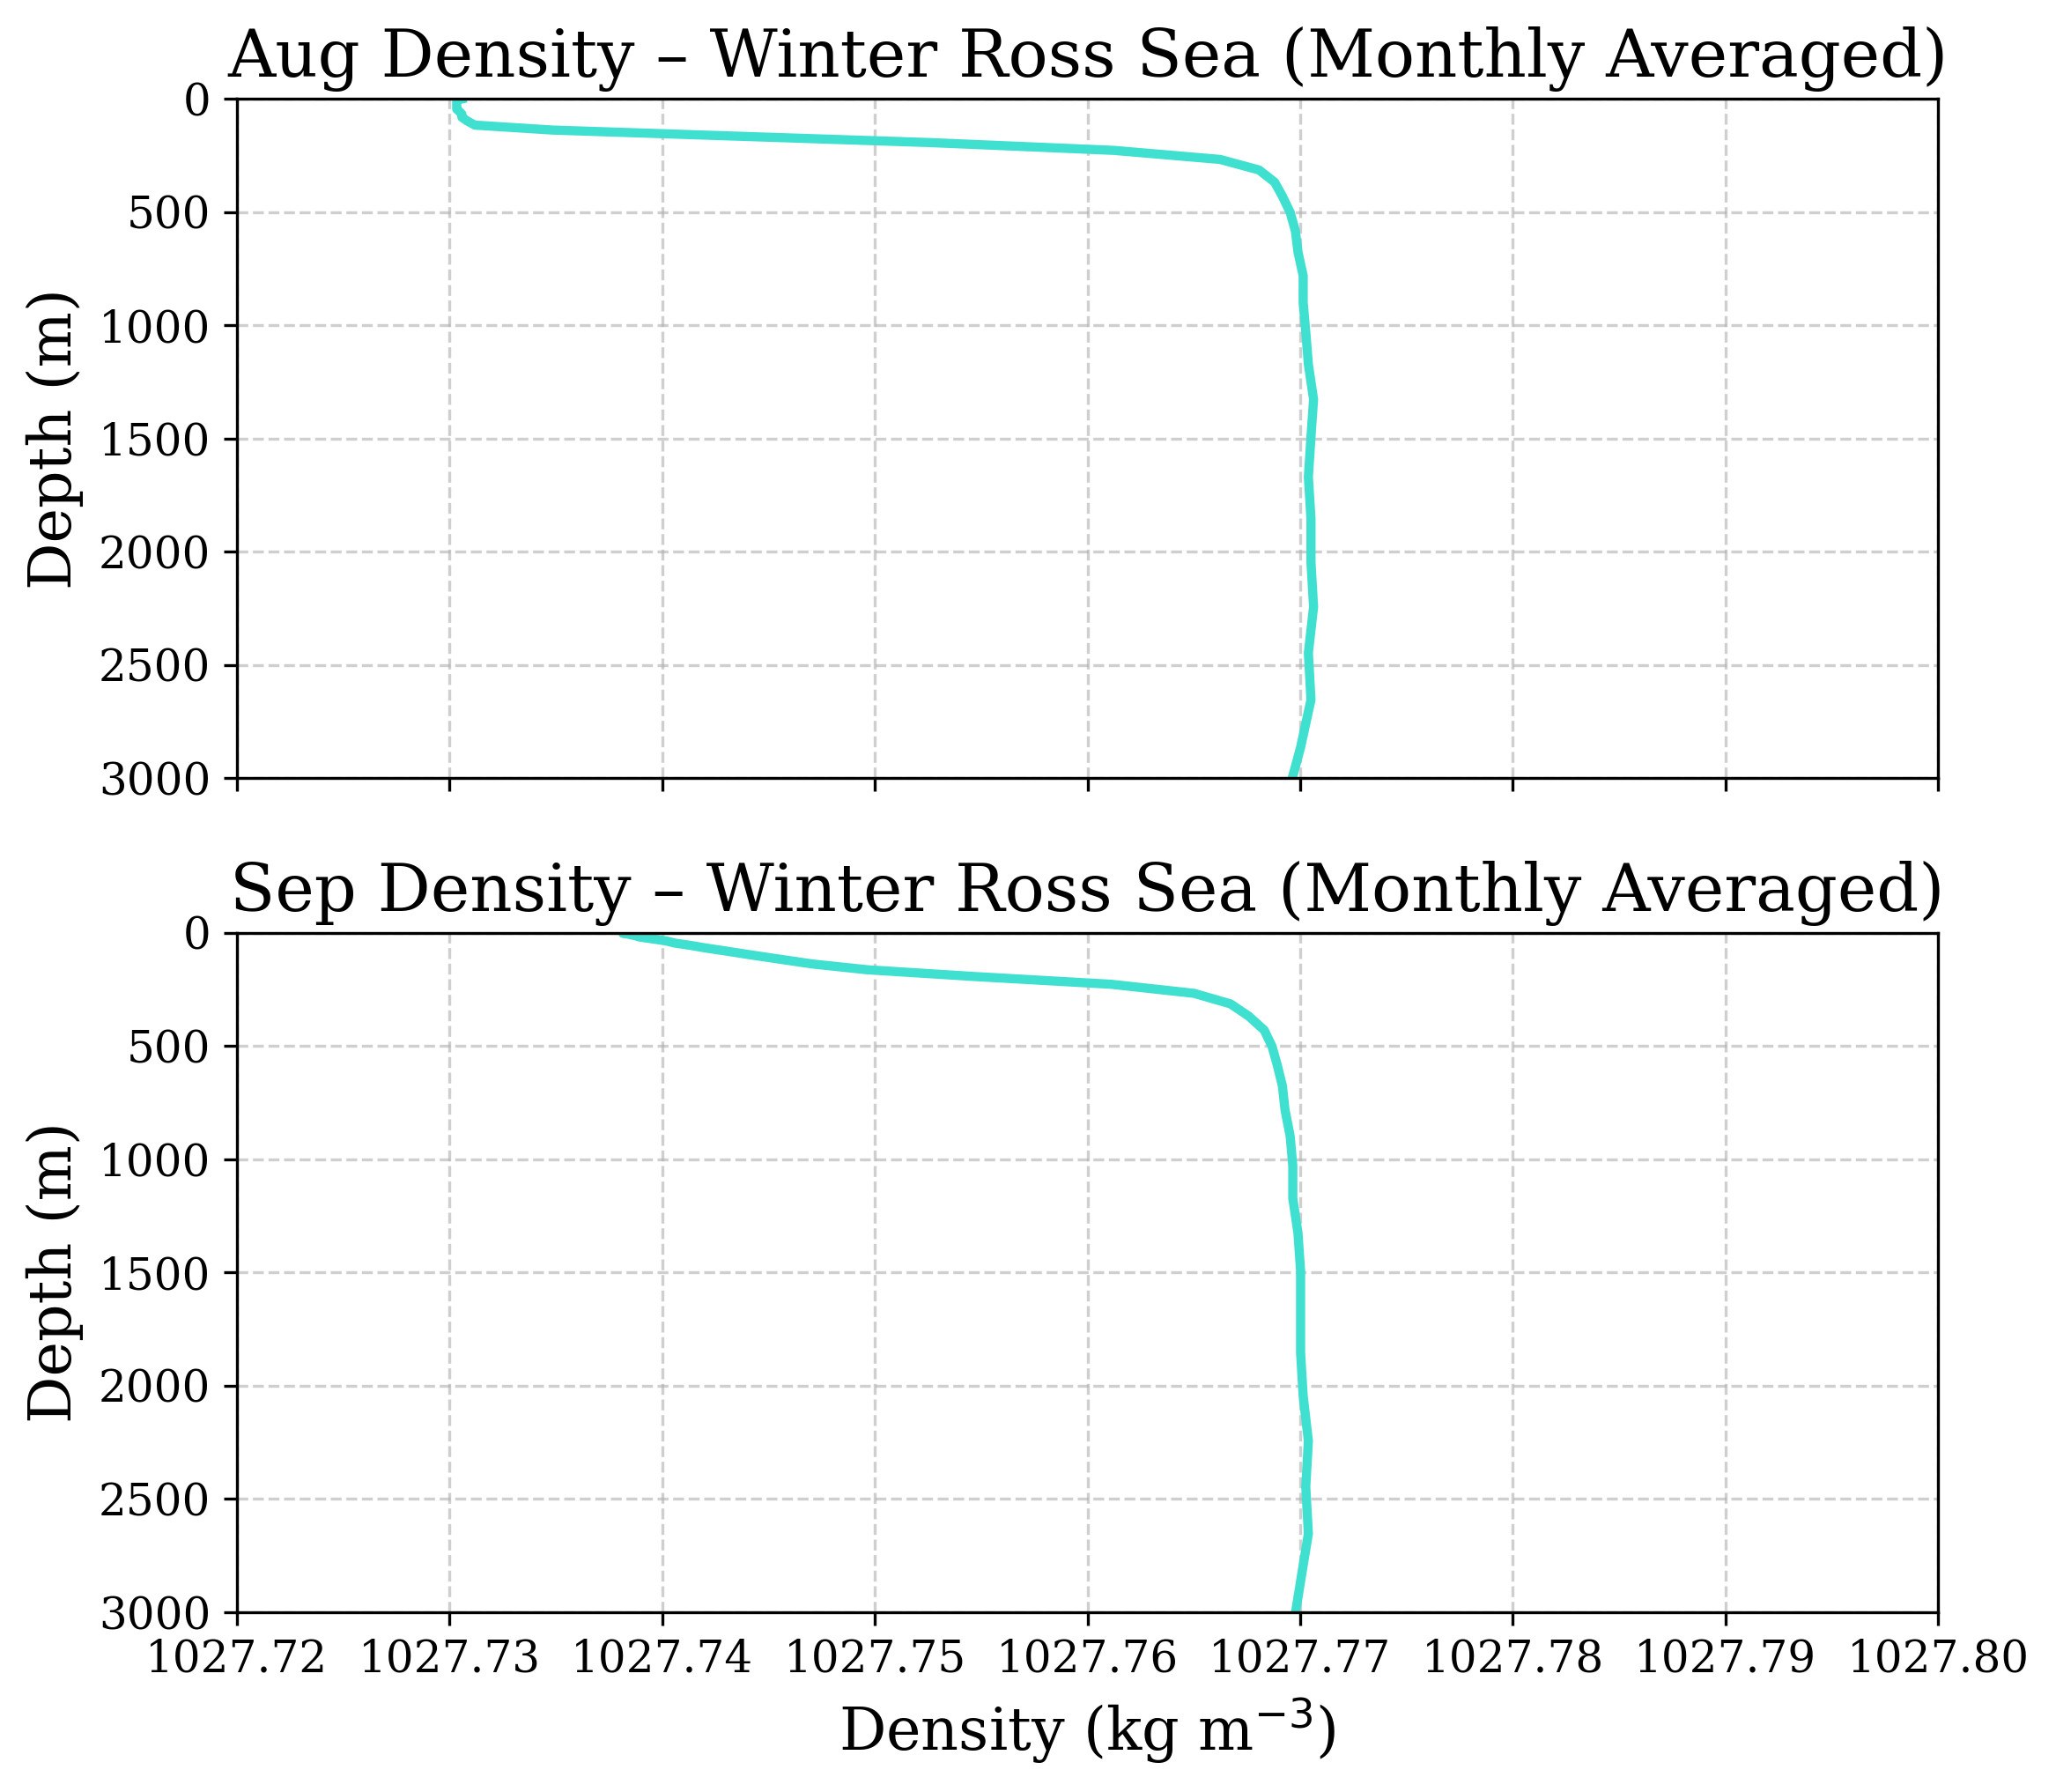

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

# --- Styling ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
})

# Months from November to May
# months = [11, 12, 1, 2, 3, 4, 5]
# month_names = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']

# months = [3, 4, 5, 6, 7, 8, 9]
# month_names = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

months = [8, 9]
month_names = ['Aug', 'Sep']

# Spatially averaged temperature anomalies
location_anom = pot.sel(yt_ocean=slice(-71,-68)). \
                               sel(xt_ocean=slice(-190, -185)).mean(dim=['yt_ocean', 'xt_ocean'])
time = location_anom["time"]

# Add year and month coordinates
location_anom = location_anom.assign_coords(
    year=time.dt.year,
    month=time.dt.month
)

# Depth coordinate for plotting
depth = location_anom.st_ocean

fig, axes = plt.subplots(len(months), 1, figsize=(8, 3.5 * len(months)), sharex=True)

# Colors
faint_color = 'lightgray'       # faint individual profiles
argo_color = '#40E0D0'          # turquoise, same as Argo profiler

for ax, month, month_name in zip(axes, months, month_names):
    # Pick year based on month
    target_year = 2020

    # Boolean mask for target year & month
    mask = (location_anom.year == target_year) & (location_anom.month == month)
    profiles = location_anom.where(mask, drop=True)

    num_profiles = profiles.time.size

    if num_profiles == 0:
        ax.text(0.5, 0.5, 'No profiles', transform=ax.transAxes,
                ha='center', va='center', fontsize=14, color='gray')
        continue

    # Plot all individual profiles faintly
    for i in range(num_profiles):
        ax.plot(profiles.values[i], depth, color=faint_color, alpha=0.2)

    # Plot mean profile in Argo color
    mean_profile = np.nanmean(profiles.values, axis=0)
    ax.plot(mean_profile, depth, color=argo_color, linewidth=2.5,
            label=f"Mean ({num_profiles})")

    #Axes settings
    ax.set_ylim(ymax = 3000, ymin=0)
    

    # X-axis ticks every 0.25°C
    # major_locator = ticker.MultipleLocator(0.5)
    # minor_locator = ticker.MultipleLocator(0.25)
    # ax.xaxis.set_major_locator(major_locator)
    # ax.xaxis.set_minor_locator(minor_locator)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    # Labels & title
    ax.set_ylabel("Depth (m)")
    ax.set_title(f"{month_name} Density – Winter Ross Sea (Monthly Averaged)")

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(xmin = 1027.72, xmax = 1027.8)
    ax.invert_yaxis()

axes[-1].set_xlabel("Density (kg m$^{-3}$)")

plt.tight_layout()
plt.show()



## Normal Temp

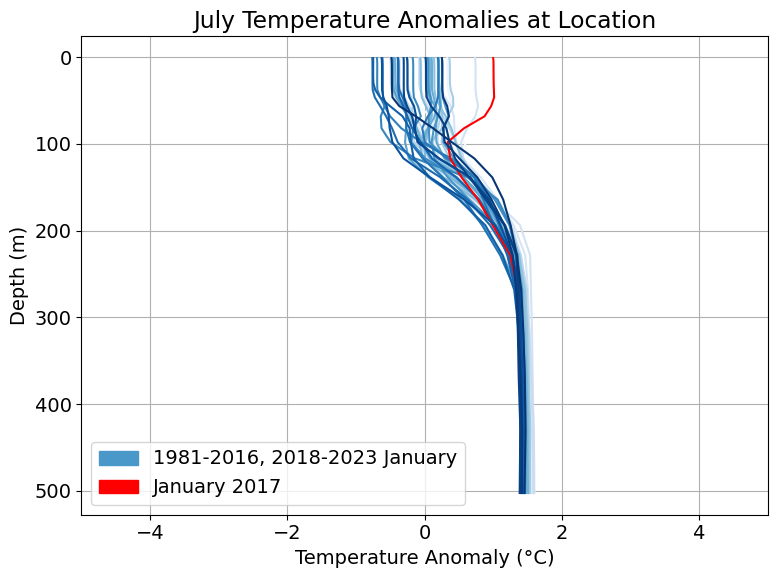

In [13]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

location_anom = temp_depth.\
                sel(yt_ocean=slice(-68,-62)).sel(xt_ocean=slice(-85,-70)).\
                mean(dim=['yt_ocean', 'xt_ocean'])

time = location_anom["time"]

# Add year and month
location_anom = location_anom.assign_coords(
    year=time.dt.year,
    month=time.dt.month
)

target_month = 5  # September
monthly_data = location_anom.sel(time=location_anom.month == target_month)

# Build year_month labels
year_str = monthly_data["year"].values.astype(str)
month_str = np.array([f"{target_month:02d}"] * len(year_str))  # force zero-padded format
year_month_labels = np.char.add(np.char.add(year_str, "_"), month_str)
monthly_data = monthly_data.assign_coords(year_month=("time", year_month_labels))

# Group and average
monthly_profiles = monthly_data.groupby("year_month").mean(dim="time")

# Plotting
fig, ax = plt.subplots(figsize=(8,6))

for i, ym in enumerate(sorted(monthly_profiles.year_month.values)):
    profile = monthly_profiles.sel(year_month=ym)
    
    if "2017_05" in ym:
        color = 'red'
    else:
        color = plt.cm.Blues(i / len(monthly_profiles.year_month))
    ax.plot(profile.values, profile.st_ocean, color=color)

ax.invert_yaxis()
# ax.set_xlabel("Salinty Anomaly (psu)")
ax.set_xlabel("Temperature Anomaly (°C)")
ax.set_ylabel("Depth (m)")
#ax.set_title("Feb Salinity Anomalies at Location")
ax.set_title("July Temperature Anomalies at Location")

# Legend
blue_patch = mpatches.Patch(color=plt.cm.Blues(0.6), label='1981-2016, 2018-2023 January')
red_patch = mpatches.Patch(color='red', label='January 2017')
ax.legend(handles=[blue_patch, red_patch], loc='best')

ax.grid(True)
ax.set_xlim(-5.,5.)

plt.tight_layout()
plt.show()

### SEANOE Dataset

In [8]:
import xarray as xr

ds = xr.open_dataset('/g/data/e14/ts7341/Subsurface_profiles/110036.nc')
ds

sal = xr.open_dataset('/g/data/e14/ts7341/Subsurface_profiles/110037.nc')

In [23]:
sal

<xarray.Dataset> Size: 4GB
Dimensions:               (SCALAR: 1, NB_DATA: 804009, NB_PROF: 601,
                           STRING63: 63)
Dimensions without coordinates: SCALAR, NB_DATA, NB_PROF, STRING63
Data variables:
    lat                   (SCALAR, NB_DATA) float64 6MB ...
    lon                   (SCALAR, NB_DATA) float64 6MB ...
    dyr                   (SCALAR, NB_DATA) float64 6MB 8.382e+03 ... 2.708e+04
    source_flag           (SCALAR, NB_DATA) float64 6MB ...
    instrument_type_flag  (SCALAR, NB_DATA) float64 6MB ...
    pres                  (NB_PROF, SCALAR) float64 5kB ...
    sa                    (NB_PROF, NB_DATA) float64 4GB ...
    bathy                 (SCALAR, NB_DATA) float64 6MB ...
    doi                   (STRING63, NB_DATA) |S1 51MB ...
    access_date           (SCALAR, NB_DATA) float64 6MB ...
Attributes:
    Authors:        Shenjie Zhou, shezhou@bas.ac.uk
    Creation Date:  09-April-2024
    Description:    OCEAN:ICE D1.1 - Pan-Antarctic (90S-45S) salinity profile...

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

# --- Styling ---
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
})

flag_to_instrument = {
    1.0: 'CTD',
    2.0: 'OSD',
    3.0: 'XBT',
    4.0: 'MBT',
    5.0: 'Argo profiler'
}

# --- Time conversion ---
time_origin = pd.Timestamp('1950-01-01')
days = ds.dyr.values.flatten()
dates = time_origin + pd.to_timedelta(days, unit='D')

# Flatten coords
lons = ds.lon.values.flatten()
lats = ds.lat.values.flatten()
method_flags = ds.instrument_type_flag.values.flatten()

# Use 0–360°E directly
lons_deg_east = lons % 360  # ensure all values are 0–360

# Define box boundaries (in 0–360°E)
lon_min, lon_max = -20, 10
lat_min, lat_max = -68, -63

# Mask profiles inside the box
in_box = (lons_deg_east >= lon_min) & (lons_deg_east <= lon_max) & (lats >= lat_min) & (lats <= lat_max)

# --- Months list ---
year = 2016
year2 = 2017
months = [(11, year), (12, year), (1, year2), (2, year2), (3, year2), (4, year2), (5, year2), (6, year2), (7, year2)]

fig, axes = plt.subplots(len(months), 1, figsize=(6, 18), sharex=True)

pres = ds.pres[:, 0].values  # pressure levels
pres_mask = pres <= 500  # mask for 0-500 dbar

# Only non-seal methods
non_seal_mask = (method_flags != 6) & (~np.isnan(method_flags))
all_selected_indices = np.where(in_box & non_seal_mask)[0]
all_selected_methods = np.unique(method_flags[all_selected_indices])
cmap = cm.get_cmap('tab10', len(all_selected_methods))
method_to_color = {method: cmap(i) for i, method in enumerate(all_selected_methods)}

for row_idx, (month, year) in enumerate(months):
    start_date_month = pd.Timestamp(year=year, month=month, day=1)
    end_date_month = (start_date_month + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)

    ax = axes[row_idx]

    in_time = (dates >= start_date_month) & (dates <= end_date_month)
    selected = in_box & in_time & non_seal_mask
    selected_indices = np.where(selected)[0]

    num_profiles = len(selected_indices)

    if num_profiles == 0:
        ax.text(0.5, 0.5, 'No profiles', transform=ax.transAxes,
                ha='center', va='center', fontsize=14, color='gray')
        ax.set_xlim(-3.0, 3.0)
        ax.set_ylim(500, 0)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_ylabel('Pressure (dbar)')
        ax.set_title(f'{start_date_month.strftime("%b %Y")} (n={num_profiles})')
        continue

    # --- Collect profiles grouped by instrument ---
    profiles_by_method = {}
    for idx in selected_indices:
        temp_profile = ds.ct[:, idx].values[pres_mask]
        method = method_flags[idx]
        if method not in profiles_by_method:
            profiles_by_method[method] = []
        profiles_by_method[method].append(temp_profile)

    # --- Plot faint individual profiles ---
    for method, prof_list in profiles_by_method.items():
        for prof in prof_list:
            ax.plot(prof, pres[pres_mask], color=method_to_color.get(method, 'gray'), alpha=0.1)

    # --- Compute and plot mean profile for each instrument type ---
    for method, prof_list in profiles_by_method.items():
        prof_array = np.vstack(prof_list)
        mean_prof = np.nanmean(prof_array, axis=0)
        ax.plot(mean_prof, pres[pres_mask],
                color=method_to_color.get(method, 'black'),
                linewidth=2.5,
                label=f"{flag_to_instrument.get(method, f'Method {method}')} ({len(prof_list)})")

    # Axes settings
    ax.set_xlim(-2.0, 3.0)
    ax.set_ylim(500, 0)
    # Draw a vertical dashed black line at x = 0
    ax.axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
    major_locator = ticker.MultipleLocator(0.5)
    minor_locator = ticker.MultipleLocator(0.25)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylabel('Pressure (dbar)')
    ax.set_title(f'{start_date_month.strftime("%b %Y")} (n={num_profiles})')

axes[-1].set_xlabel('Temp (°C)')

# --- Combined legend ---
handles = [plt.Line2D([], [], color=method_to_color[m], linewidth=2.5,
                      label=flag_to_instrument.get(m, f'Method {m}'))
           for m in all_selected_methods if not np.isnan(m)]
fig.legend(handles, [flag_to_instrument.get(m, f'Method {m}') for m in all_selected_methods if not np.isnan(m)],
           title='Instrument Type', loc='upper center', bbox_to_anchor=(0.5, 0.02),
           frameon=False, ncol=3, fontsize=14)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()



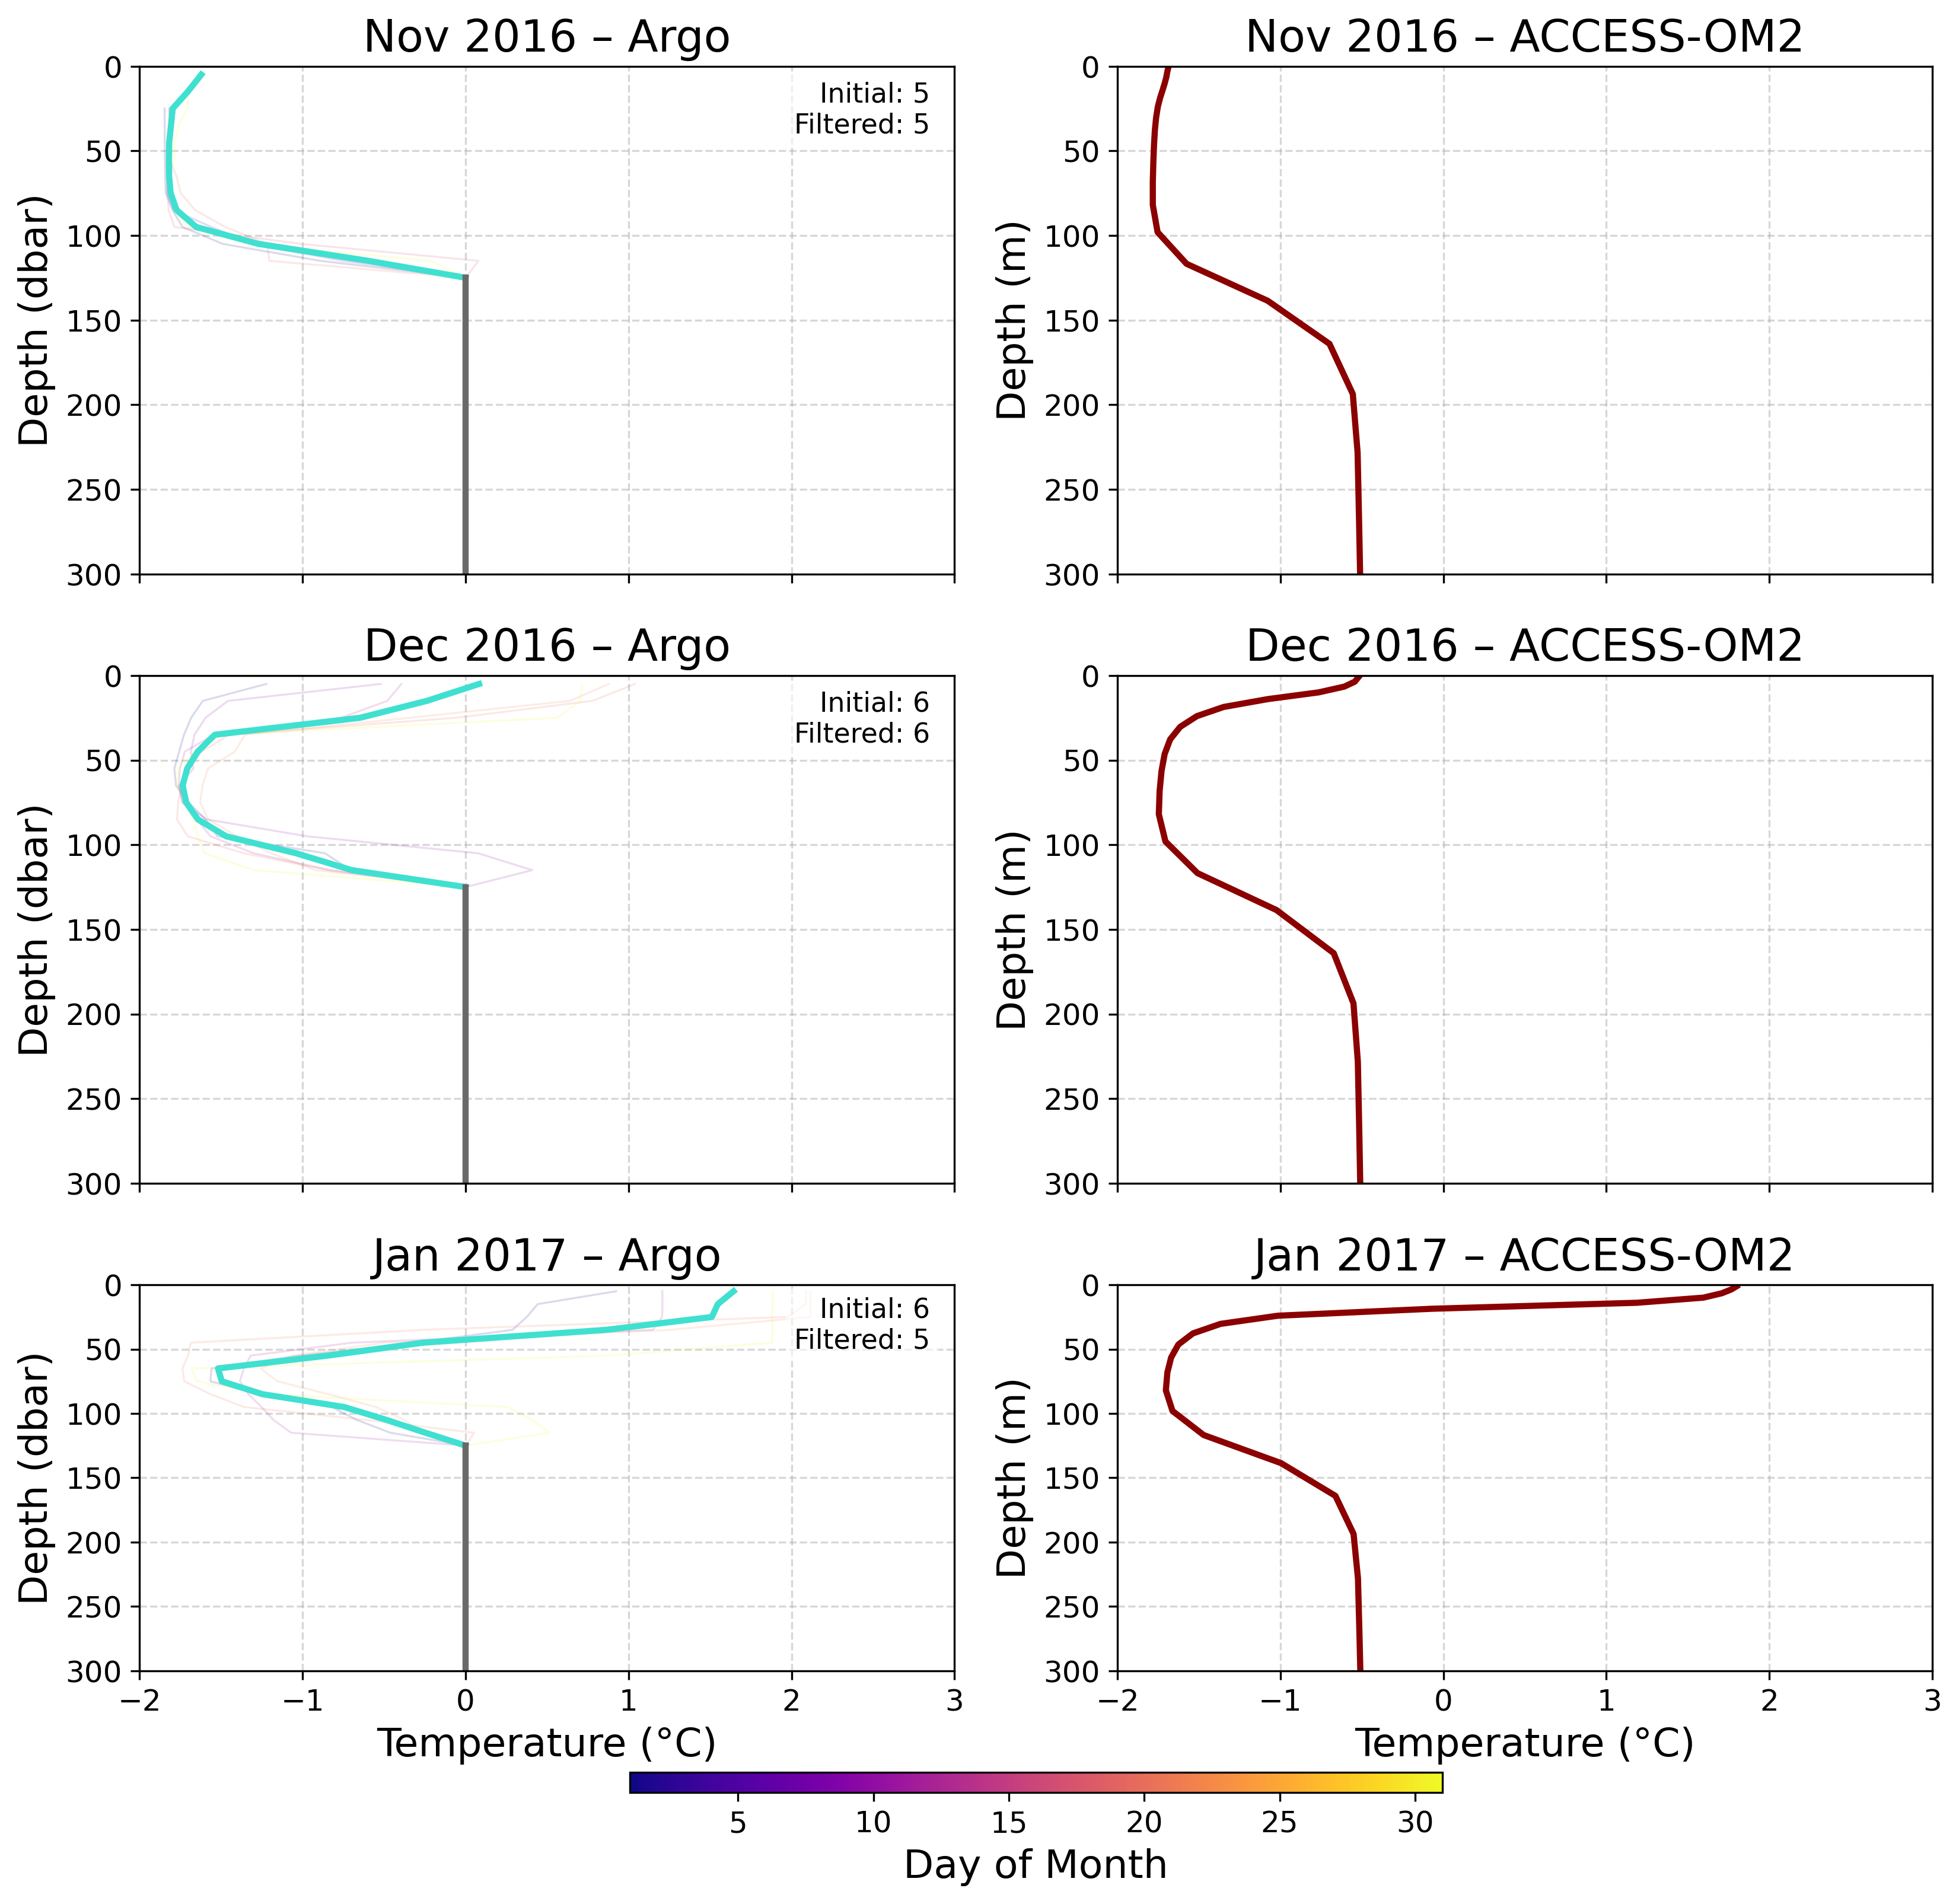

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable

# This line is only needed if you are in a Jupyter Notebook/IPython environment
%matplotlib inline

# --- Styling ---
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
})

# NOTE: The following lines assume your data variables (temp_depth, ds, sal)
# are already loaded in your environment.

# --- Months to compare (February removed) ---
months = [11, 12, 1]
month_names = ['Nov', 'Dec', 'Jan']

# --- Extract model anomalies ---
location_anom = temp_depth.sel(yt_ocean=slice(-68, -63)) \
                          .sel(xt_ocean=slice(-20, 10)) \
                          .mean(dim=['yt_ocean', 'xt_ocean']).sel(st_ocean=slice(0, 400))
time = location_anom["time"]
location_anom = location_anom.assign_coords(year=time.dt.year, month=time.dt.month)
depth_model = location_anom.st_ocean

# --- Argo data preprocessing ---
time_origin = pd.Timestamp('1950-01-01')
days = sal.dyr.values.flatten()
dates = time_origin + pd.to_timedelta(days, unit='D')  # DatetimeIndex

lons = ds.lon.values.flatten()
lats = ds.lat.values.flatten()
method_flags = ds.instrument_type_flag.values.flatten()

argo_mask = (method_flags == 5) & (~np.isnan(method_flags))

# Spatial box (Ross Sea)
lons_deg_east = lons % 360
in_box = ((lons_deg_east >= 340) | (lons_deg_east <= 10)) & \
         (lats >= -68) & (lats <= -63)

# Depth (pressure)
pres = ds.pres[:, 0].values
pres_mask = pres <= 500

# --- Figure layout (adjusts automatically to 3 rows) ---
fig, axes = plt.subplots(len(months), 2, figsize=(13, 4.2 * len(months)), sharex=True)

# Colors
argo_mean_color = '#40E0D0'
model_mean_color = '#8B0000'
model_faint_color = '#d3d3d3'
cmap = plt.cm.plasma
# --- NEW COLORS FOR GREYING OUT ---
deep_argo_color = 'grey'
deep_argo_mean_color = '#696969' # dimgrey for better visibility

for row, (month, month_name) in enumerate(zip(months, month_names)):
    # -------- Argo (left column) --------
    ax_argo = axes[row, 0]
    target_year = 2016 if month in (11, 12) else 2017
    
    in_time = (dates.year == target_year) & (dates.month == month)
    selected = in_box & argo_mask & in_time
    indices = np.where(selected)[0]
    
    initial_count = len(indices)
    n_profiles = 0
    
    if initial_count > 0:
        candidate_profiles_data = [ds.ct[:, idx].values[pres_mask] for idx in indices]
        candidate_days = dates[indices].day

        # The entire filtering process remains unchanged
        pre_filtered_profiles = []
        pre_filtered_days = []
        if month == 1 and len(candidate_profiles_data) > 0:
            surface_indices = np.where(pres[pres_mask] <= 10)[0]
            depth_70m_idx = np.argmin(np.abs(pres[pres_mask] - 70))
            for profile, day in zip(candidate_profiles_data, candidate_days):
                is_too_cold_at_surface = False
                if surface_indices.size > 0:
                    surface_temp_min = np.nanmin(profile[surface_indices])
                    if not np.isnan(surface_temp_min) and surface_temp_min < 0:
                        is_too_cold_at_surface = True
                is_too_warm_at_depth = False
                temp_at_70m = profile[depth_70m_idx]
                if not np.isnan(temp_at_70m) and temp_at_70m > 0:
                    is_too_warm_at_depth = True
                if not (is_too_cold_at_surface or is_too_warm_at_depth):
                    pre_filtered_profiles.append(profile)
                    pre_filtered_days.append(day)
        else:
            pre_filtered_profiles = candidate_profiles_data
            pre_filtered_days = candidate_days

        final_profiles = []
        final_days = []
        if len(pre_filtered_profiles) > 3:
            profiles_array = np.vstack(pre_filtered_profiles)
            mean_at_depth = np.nanmean(profiles_array, axis=0)
            std_at_depth = np.nanstd(profiles_array, axis=0)
            upper_bound = mean_at_depth + 3.0 * std_at_depth
            lower_bound = mean_at_depth - 3.0 * std_at_depth
            for i, profile in enumerate(pre_filtered_profiles):
                outlier_points = np.sum(((profile < lower_bound) | (profile > upper_bound)) & ~np.isnan(profile))
                if outlier_points <= 5:
                    final_profiles.append(profile)
                    final_days.append(pre_filtered_days[i])
        else:
            final_profiles = pre_filtered_profiles
            final_days = pre_filtered_days

        if len(final_profiles) > 0:
            n_profiles = len(final_profiles)
            final_days = np.array(final_days)
            
            # --- Find the index to split the data at 110 dbar ---
            cutoff_idx = np.searchsorted(pres[pres_mask], 120)

            day_range = final_days.max() - final_days.min()
            norm_days = (final_days - final_days.min()) / day_range if day_range > 0 else np.full_like(final_days, 0.5, dtype=float)
            
            # --- Plot each profile in two parts ---
            for profile, n_day in zip(final_profiles, norm_days):
                # Plot shallow part (<=110m) in color
                ax_argo.plot(profile[:cutoff_idx+1], pres[pres_mask][:cutoff_idx+1], color=cmap(n_day), alpha=0.15, linewidth=0.8)
                # Plot deep part (>110m) in grey
                ax_argo.plot(profile[cutoff_idx:], pres[pres_mask][cutoff_idx:], color=deep_argo_color, alpha=0.15, linewidth=0.8)
            
            mean_prof = np.nanmean(np.vstack(final_profiles), axis=0)
            # Plot shallow mean in color and add the legend label
            ax_argo.plot(mean_prof[:cutoff_idx+1], pres[pres_mask][:cutoff_idx+1], color=argo_mean_color, linewidth=2.5)
            # Plot deep mean in a darker grey, with no label
            ax_argo.plot(mean_prof[cutoff_idx:], pres[pres_mask][cutoff_idx:], color=deep_argo_mean_color, linewidth=2.5)

    count_text = f"Initial: {initial_count}\nFiltered: {n_profiles}"
    ax_argo.text(0.97, 0.97, count_text,
                 transform=ax_argo.transAxes,
                 fontsize=11,
                 verticalalignment='top',
                 horizontalalignment='right',
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.6, ec='none'))

    ax_argo.set_ylim(0, 300)
    ax_argo.invert_yaxis()
    ax_argo.set_xlim(-2, 3)
    ax_argo.set_ylabel("Depth (dbar)")
    ax_argo.set_title(f"{month_name} {target_year} – Argo")
    ax_argo.grid(True, linestyle='--', alpha=0.5)

    # -------- Model (right column) --------
    ax_model = axes[row, 1]
    mask = (location_anom.year == target_year) & (location_anom.month == month)
    profiles_model = location_anom.where(mask, drop=True)

    if profiles_model.time.size > 0:
        for i in range(profiles_model.time.size):
            ax_model.plot(profiles_model.values[i], depth_model,
                          color=model_faint_color, alpha=0.15, linewidth=0.8)
        mean_model = np.nanmean(profiles_model.values, axis=0)
        ax_model.plot(mean_model, depth_model, color=model_mean_color, linewidth=2.5)

    ax_model.set_ylim(0, 300)
    ax_model.invert_yaxis()
    ax_model.set_xlim(-2, 3)
    ax_model.set_ylabel("Depth (m)")
    ax_model.set_title(f"{month_name} {target_year} – ACCESS-OM2")
    ax_model.grid(True, linestyle='--', alpha=0.5)

# --- Shared X label ---
for ax in axes[-1, :]:
    ax.set_xlabel("Temperature (°C)")

# --- Colorbar (positioned under the last row - January) ---
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=31))
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes[-1, :],
                    orientation='horizontal',
                    fraction=0.04,
                    pad=0.2,
                    aspect=40)
cbar.set_label('Day of Month')
 
# --- Add legend for mean on top-left panel ---
if n_profiles > 0:
    axes[0, 0].legend(frameon=False, loc='upper right')



plt.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/argo_model_comparison_WS_temp.png', dpi=300, bbox_inches='tight')

plt.show()

In [21]:
import cosima_cookbook as cc
salt = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='salt', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='1957-12-31 00:00:00', 
                          end_time='2023-11-30 00:00:00')

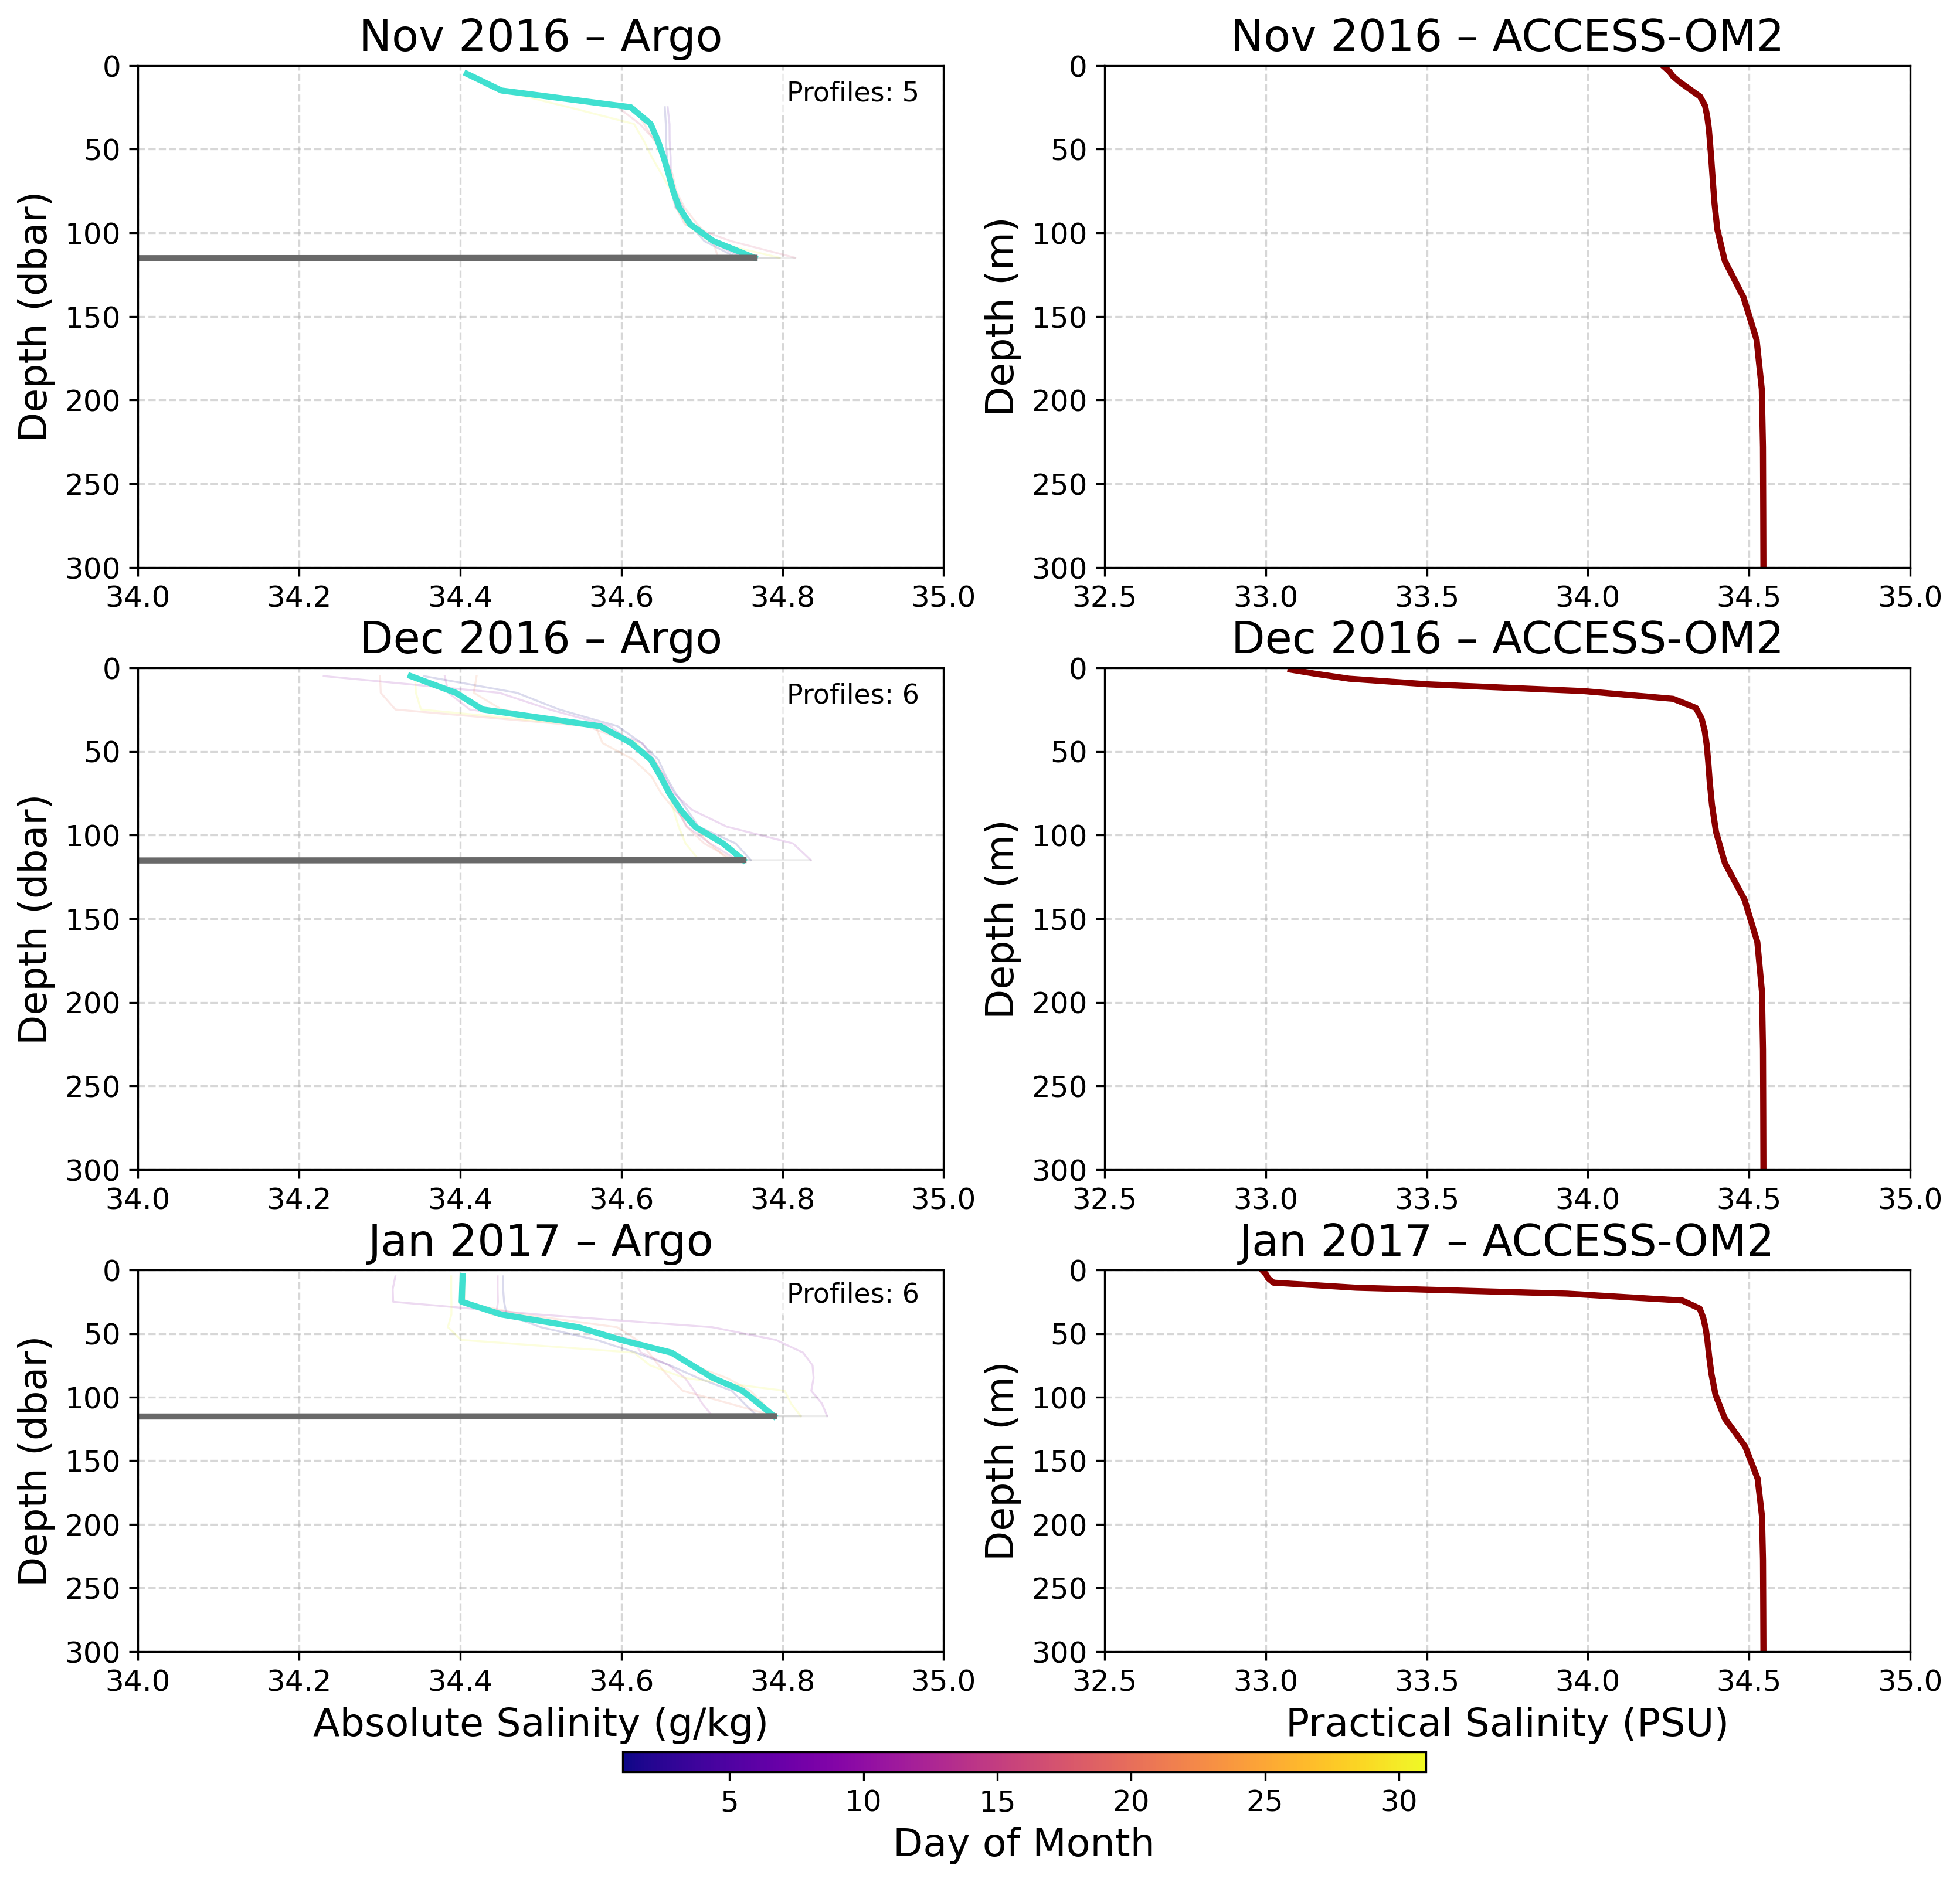

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable

# This line is only needed if you are in a Jupyter Notebook/IPython environment
%matplotlib inline

# --- Styling ---
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
})

# NOTE: The following lines assume your data variables (salt, sal)
# are already loaded in your environment.

# --- Months to compare (February removed) ---
months = [11, 12, 1]
month_names = ['Nov', 'Dec', 'Jan']

# --- Extract model data (now using 'salt') ---
location_anom = salt.sel(yt_ocean=slice(-68, -63)) \
                          .sel(xt_ocean=slice(-20, 10)) \
                          .mean(dim=['yt_ocean', 'xt_ocean']).sel(st_ocean=slice(0, 400))
time = location_anom["time"]
location_anom = location_anom.assign_coords(year=time.dt.year, month=time.dt.month)
depth_model = location_anom.st_ocean

# --- Argo data preprocessing ---
time_origin = pd.Timestamp('1950-01-01')
days = sal.dyr.values.flatten()
dates = time_origin + pd.to_timedelta(days, unit='D')

lons = sal.lon.values.flatten()
lats = sal.lat.values.flatten()
method_flags = sal.instrument_type_flag.values.flatten()

argo_mask = (method_flags == 5) & (~np.isnan(method_flags))

# Spatial box (Ross Sea)
lons_deg_east = lons % 360
in_box = ((lons_deg_east >= 340) | (lons_deg_east <= 10)) & \
         (lats >= -68) & (lats <= -63)

# Depth (pressure)
pres = sal.pres[:, 0].values
pres_mask = pres <= 500

# --- Figure layout ---
# Removed sharex=True to allow for different x-axis labels
fig, axes = plt.subplots(len(months), 2, figsize=(13, 4.2 * len(months))) 

# Colors
argo_mean_color = '#40E0D0'
model_mean_color = '#8B0000'
model_faint_color = '#d3d3d3'
cmap = plt.cm.plasma
# --- NEW COLORS FOR GREYING OUT ---
deep_argo_color = 'grey'
deep_argo_mean_color = '#696969' # dimgrey for better visibility

for row, (month, month_name) in enumerate(zip(months, month_names)):
    # -------- Argo (left column) --------
    ax_argo = axes[row, 0]
    target_year = 2016 if month in (11, 12) else 2017
    
    in_time = (dates.year == target_year) & (dates.month == month)
    selected = in_box & argo_mask & in_time
    indices = np.where(selected)[0]
    
    n_profiles = len(indices)
    
    if n_profiles > 0:
        all_profiles = [sal.sa[:, idx].values[pres_mask] for idx in indices]
        all_days = dates[indices].day
        
        # --- Find the index to split the data at 125 dbar ---
        # Using searchsorted is efficient and finds the correct insertion point
        cutoff_idx = np.searchsorted(pres[pres_mask], 110)
        
        day_range = all_days.max() - all_days.min()
        norm_days = (all_days - all_days.min()) / day_range if day_range > 0 else np.full_like(all_days, 0.5, dtype=float)
        
        # --- Plot each profile in two parts ---
        for profile, n_day in zip(all_profiles, norm_days):
            # Plot shallow part (<=125m) in color
            ax_argo.plot(profile[:cutoff_idx+1], pres[pres_mask][:cutoff_idx+1], color=cmap(n_day), alpha=0.15, linewidth=0.8)
            # Plot deep part (>125m) in grey
            ax_argo.plot(profile[cutoff_idx:], pres[pres_mask][cutoff_idx:], color=deep_argo_color, alpha=0.15, linewidth=0.8)
    
        mean_prof = np.nanmean(np.vstack(all_profiles), axis=0)
        # Plot shallow mean in color and add the legend label
        ax_argo.plot(mean_prof[:cutoff_idx+1], pres[pres_mask][:cutoff_idx+1], color=argo_mean_color, linewidth=2.5)
        # Plot deep mean in a darker grey, with no label
        ax_argo.plot(mean_prof[cutoff_idx:], pres[pres_mask][cutoff_idx:], color=deep_argo_mean_color, linewidth=2.5)

    count_text = f"Profiles: {n_profiles}"
    ax_argo.text(0.97, 0.97, count_text,
                 transform=ax_argo.transAxes, fontsize=11,
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.6, ec='none'))

    ax_argo.set_ylim(0, 300)
    ax_argo.invert_yaxis()
    ax_argo.set_xlim(34, 35) # Reset xlim for better view
    ax_argo.set_ylabel("Depth (dbar)")
    ax_argo.set_title(f"{month_name} {target_year} – Argo")
    ax_argo.grid(True, linestyle='--', alpha=0.5)

    # -------- Model (right column) --------
    ax_model = axes[row, 1]
    mask = (location_anom.year == target_year) & (location_anom.month == month)
    profiles_model = location_anom.where(mask, drop=True)

    if profiles_model.time.size > 0:
        for i in range(profiles_model.time.size):
            ax_model.plot(profiles_model.values[i], depth_model,
                          color=model_faint_color, alpha=0.15, linewidth=0.8)
        mean_model = np.nanmean(profiles_model.values, axis=0)
        ax_model.plot(mean_model, depth_model, color=model_mean_color, linewidth=2.5)

    ax_model.set_ylim(0, 300)
    ax_model.invert_yaxis()
    ax_model.set_xlim(32.5, 35) # Reset xlim for better view
    ax_model.set_ylabel("Depth (m)")
    ax_model.set_title(f"{month_name} {target_year} – ACCESS-OM2")
    ax_model.grid(True, linestyle='--', alpha=0.5)

# --- Set separate X labels for each column ---
axes[-1, 0].set_xlabel("Absolute Salinity (g/kg)")
axes[-1, 1].set_xlabel("Practical Salinity (PSU)")

# --- Colorbar ---
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=31))
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes[-1, :],
                    orientation='horizontal', fraction=0.04,
                    pad=0.2, aspect=40)
cbar.set_label('Day of Month')
 
# --- Add legend for mean on top-left panel ---
if n_profiles > 0:
    axes[0, 0].legend(frameon=False, loc='upper right')

plt.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/argo_model_comparison_WS_salt.png', dpi=300, bbox_inches='tight')

plt.show()

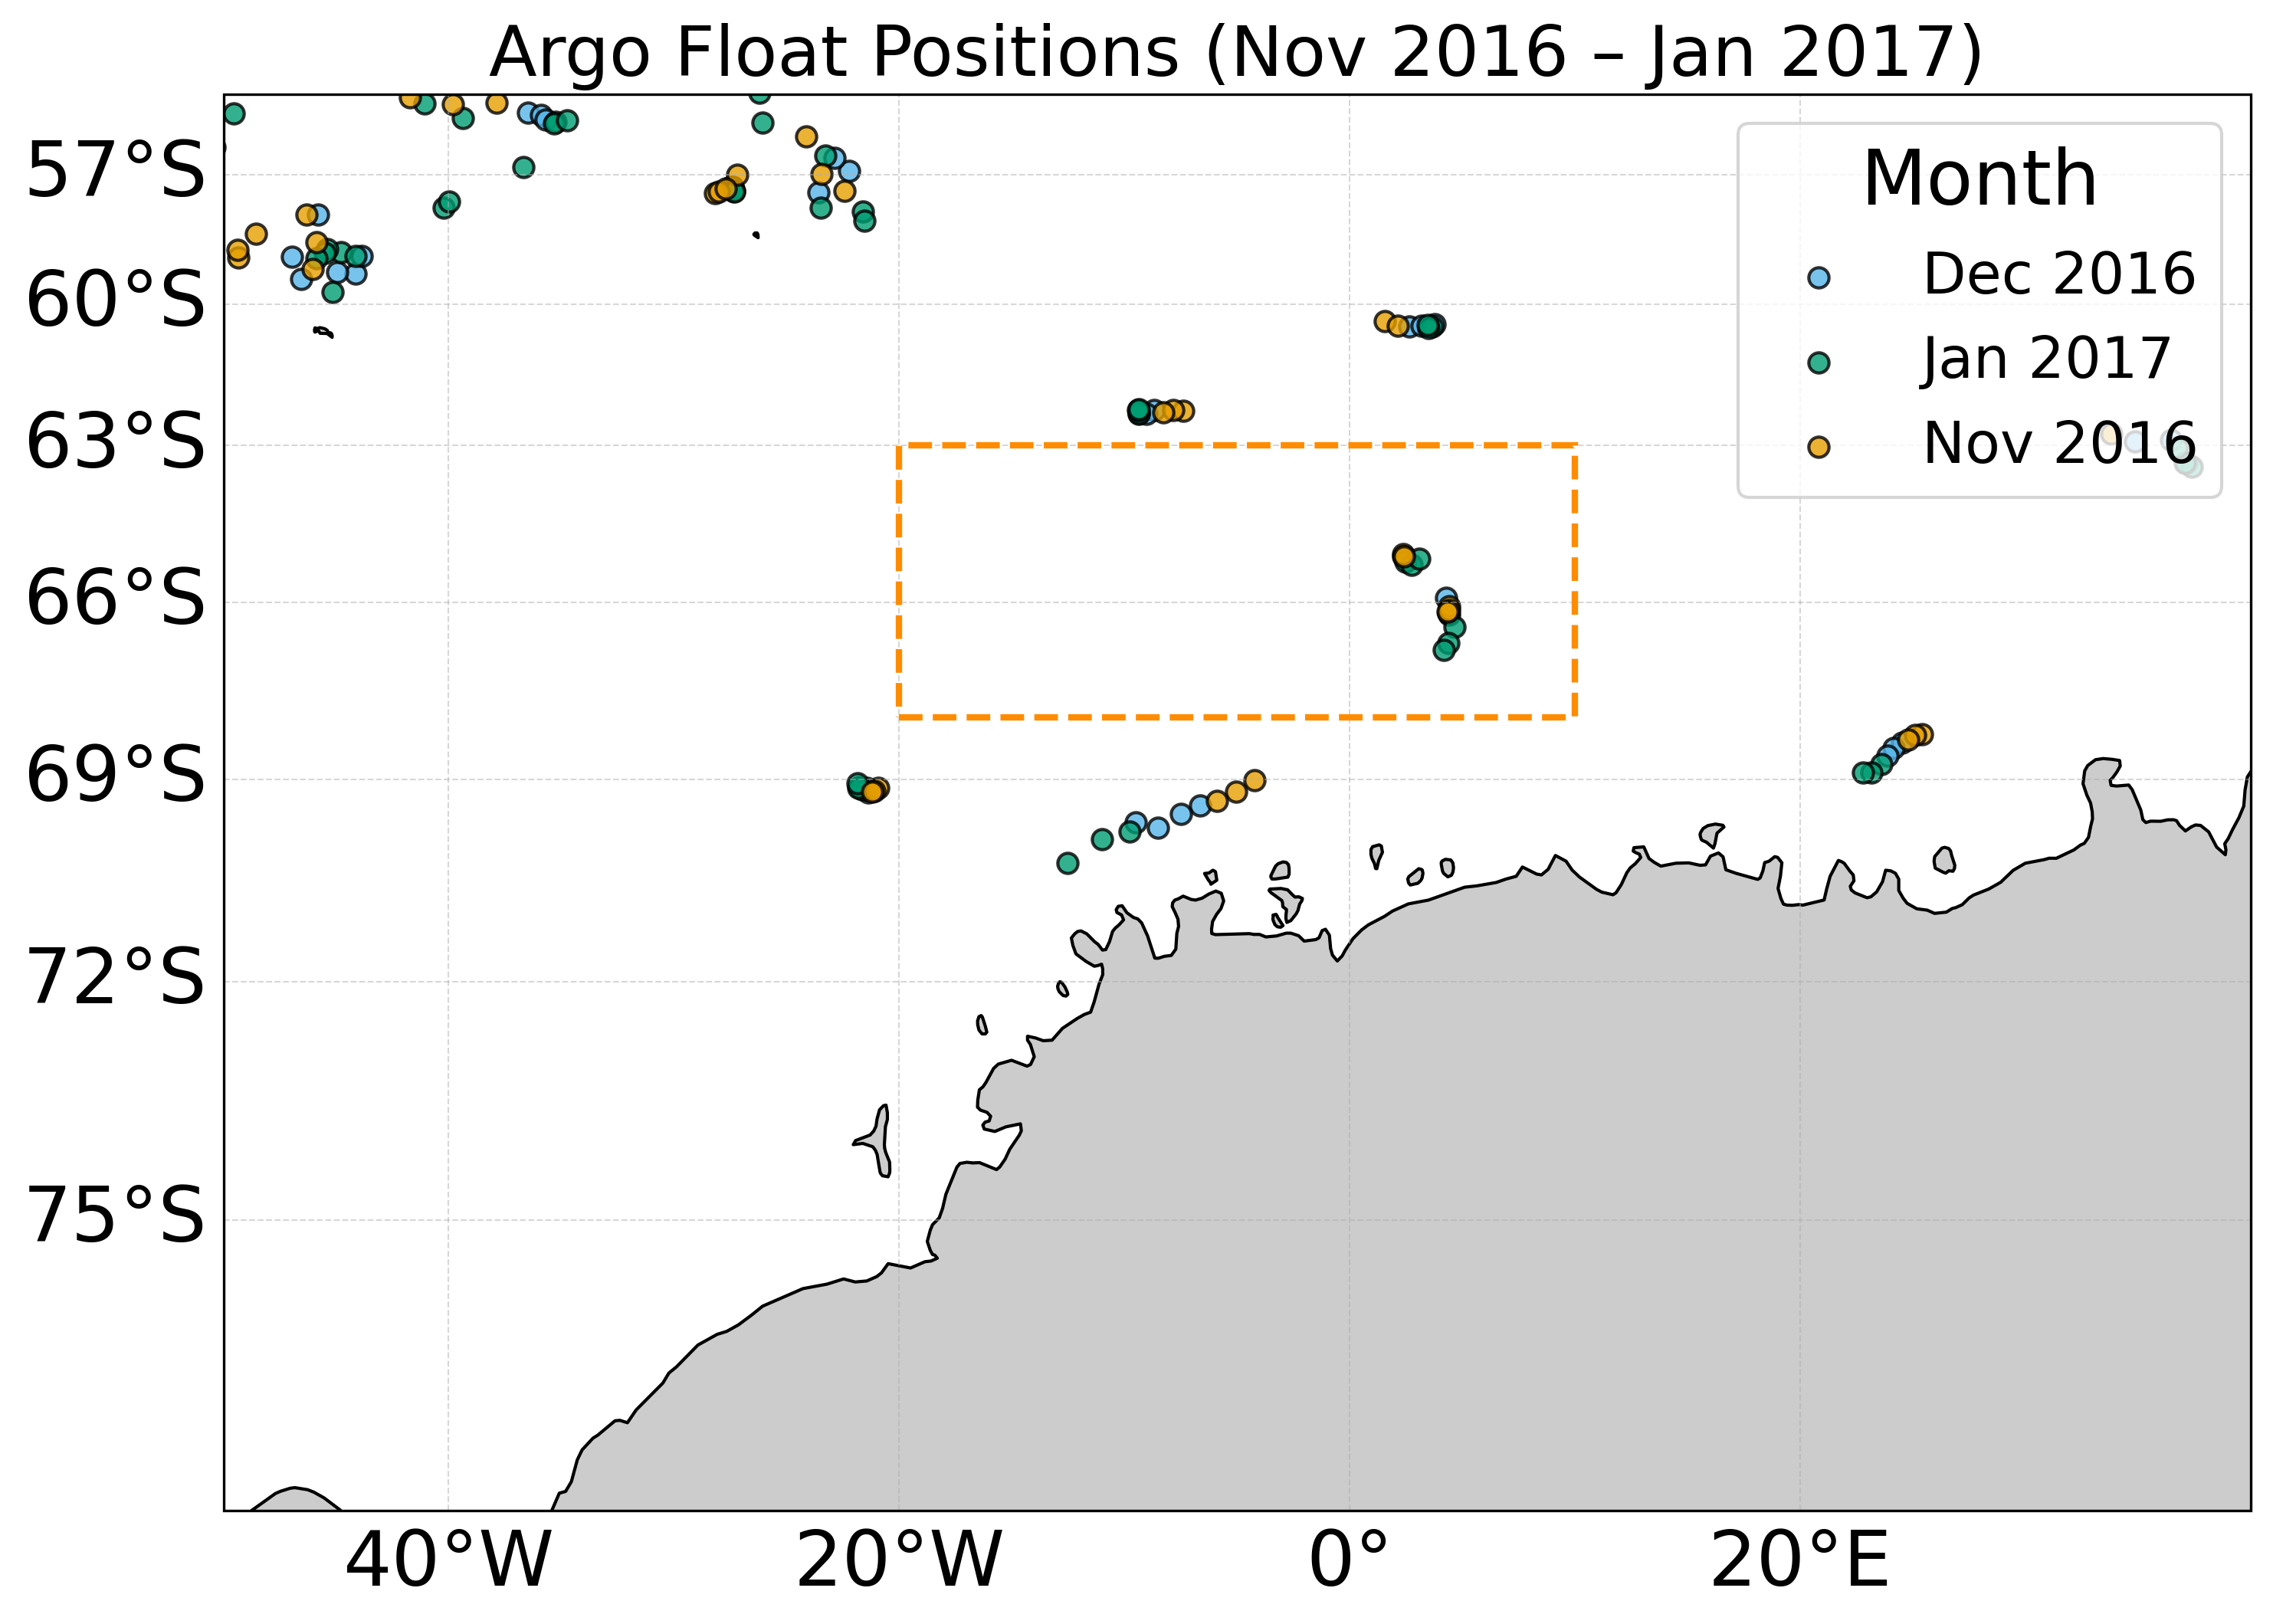

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# -------------------------
# --- Styling (NEW) ---
# -------------------------
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 24,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'legend.fontsize': 18,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 300,
})

# -------------------------
# --- Data preparation ----
# -------------------------
time_origin = pd.Timestamp('1950-01-01')

# Using 'sal' as the source for complete metadata
days = sal.dyr.values.flatten()
dates = time_origin + pd.to_timedelta(days, unit='D')

# Flatten coordinates from the correct source
lons = sal.lon.values.flatten()
lats = sal.lat.values.flatten()
method_flags = sal.instrument_type_flag.values.flatten()

# Normalize longitudes to [-180, 180]
lons_norm = ((lons + 180) % 360) - 180

# --- Time filtering: Nov 2016 – Jan 2017 ---
time_start = pd.Timestamp('2016-11-01')
time_end   = pd.Timestamp('2017-01-31')
time_mask = (dates >= time_start) & (dates <= time_end)

# --- Mask Argo floats within time frame and type ---
argo_mask = (method_flags == 5.0) & time_mask
argo_lons = lons_norm[argo_mask]
argo_lats = lats[argo_mask]
months = dates[argo_mask].month

# Color-blind-friendly palette for Nov, Dec, Jan
month_colors = {11: "#E69F00", 12: "#56B4E9", 1: "#009E73"}  # orange, blue, green
month_labels = {11: "Nov 2016", 12: "Dec 2016", 1: "Jan 2017"}

# -------------------------
# --- Plotting -------------
# -------------------------
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

# Full Weddell Sea extent
extent = [-50, 40, -78, -55]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Land and coastlines
land = cft.NaturalEarthFeature('physical', 'land', '50m',
                               edgecolor='black', facecolor='0.8')
ax.add_feature(land)
ax.coastlines(resolution='50m', linewidth=0.5)

# Gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, alpha=0.5)
gl.top_labels = False
gl.right_labels = False
# Removed specific font sizes to inherit from rcParams
gl.xlabel_style = {}
gl.ylabel_style = {}

# Define a specific plot order to draw November last
plot_order = [12, 1, 11] # Plot Dec, then Jan, then Nov on top

jitter_degree = 0.05
for month in plot_order:
    color = month_colors[month]
    label = month_labels[month]
    
    mask = (months == month)
    jittered_lons = argo_lons[mask] + np.random.uniform(-jitter_degree, jitter_degree, size=mask.sum())
    jittered_lats = argo_lats[mask] + np.random.uniform(-jitter_degree, jitter_degree, size=mask.sum())
    
    ax.scatter(jittered_lons, jittered_lats,
               color=color, s=40, edgecolor='k', alpha=0.8,
               transform=ccrs.PlateCarree(),
               label=label)

# Add a box for the specific region
box_lon_min, box_lon_max = -20, 10
box_lat_min, box_lat_max = -68, -63
region_box = mpatches.Rectangle(
    (box_lon_min, box_lat_min),
    box_lon_max - box_lon_min,
    box_lat_max - box_lat_min,
    linewidth=2, edgecolor='darkorange',
    linestyle='--', facecolor='none',
    transform=ccrs.PlateCarree(), zorder=10
)
ax.add_patch(region_box)

# Title and legend - removed specific font sizes to inherit from rcParams
ax.set_title("Argo Float Positions (Nov 2016 – Jan 2017)")
ax.legend(frameon=True, loc='upper right', title="Month")

plt.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/argo_location.png', dpi=300, bbox_inches='tight')

plt.show()

## Case Study 2

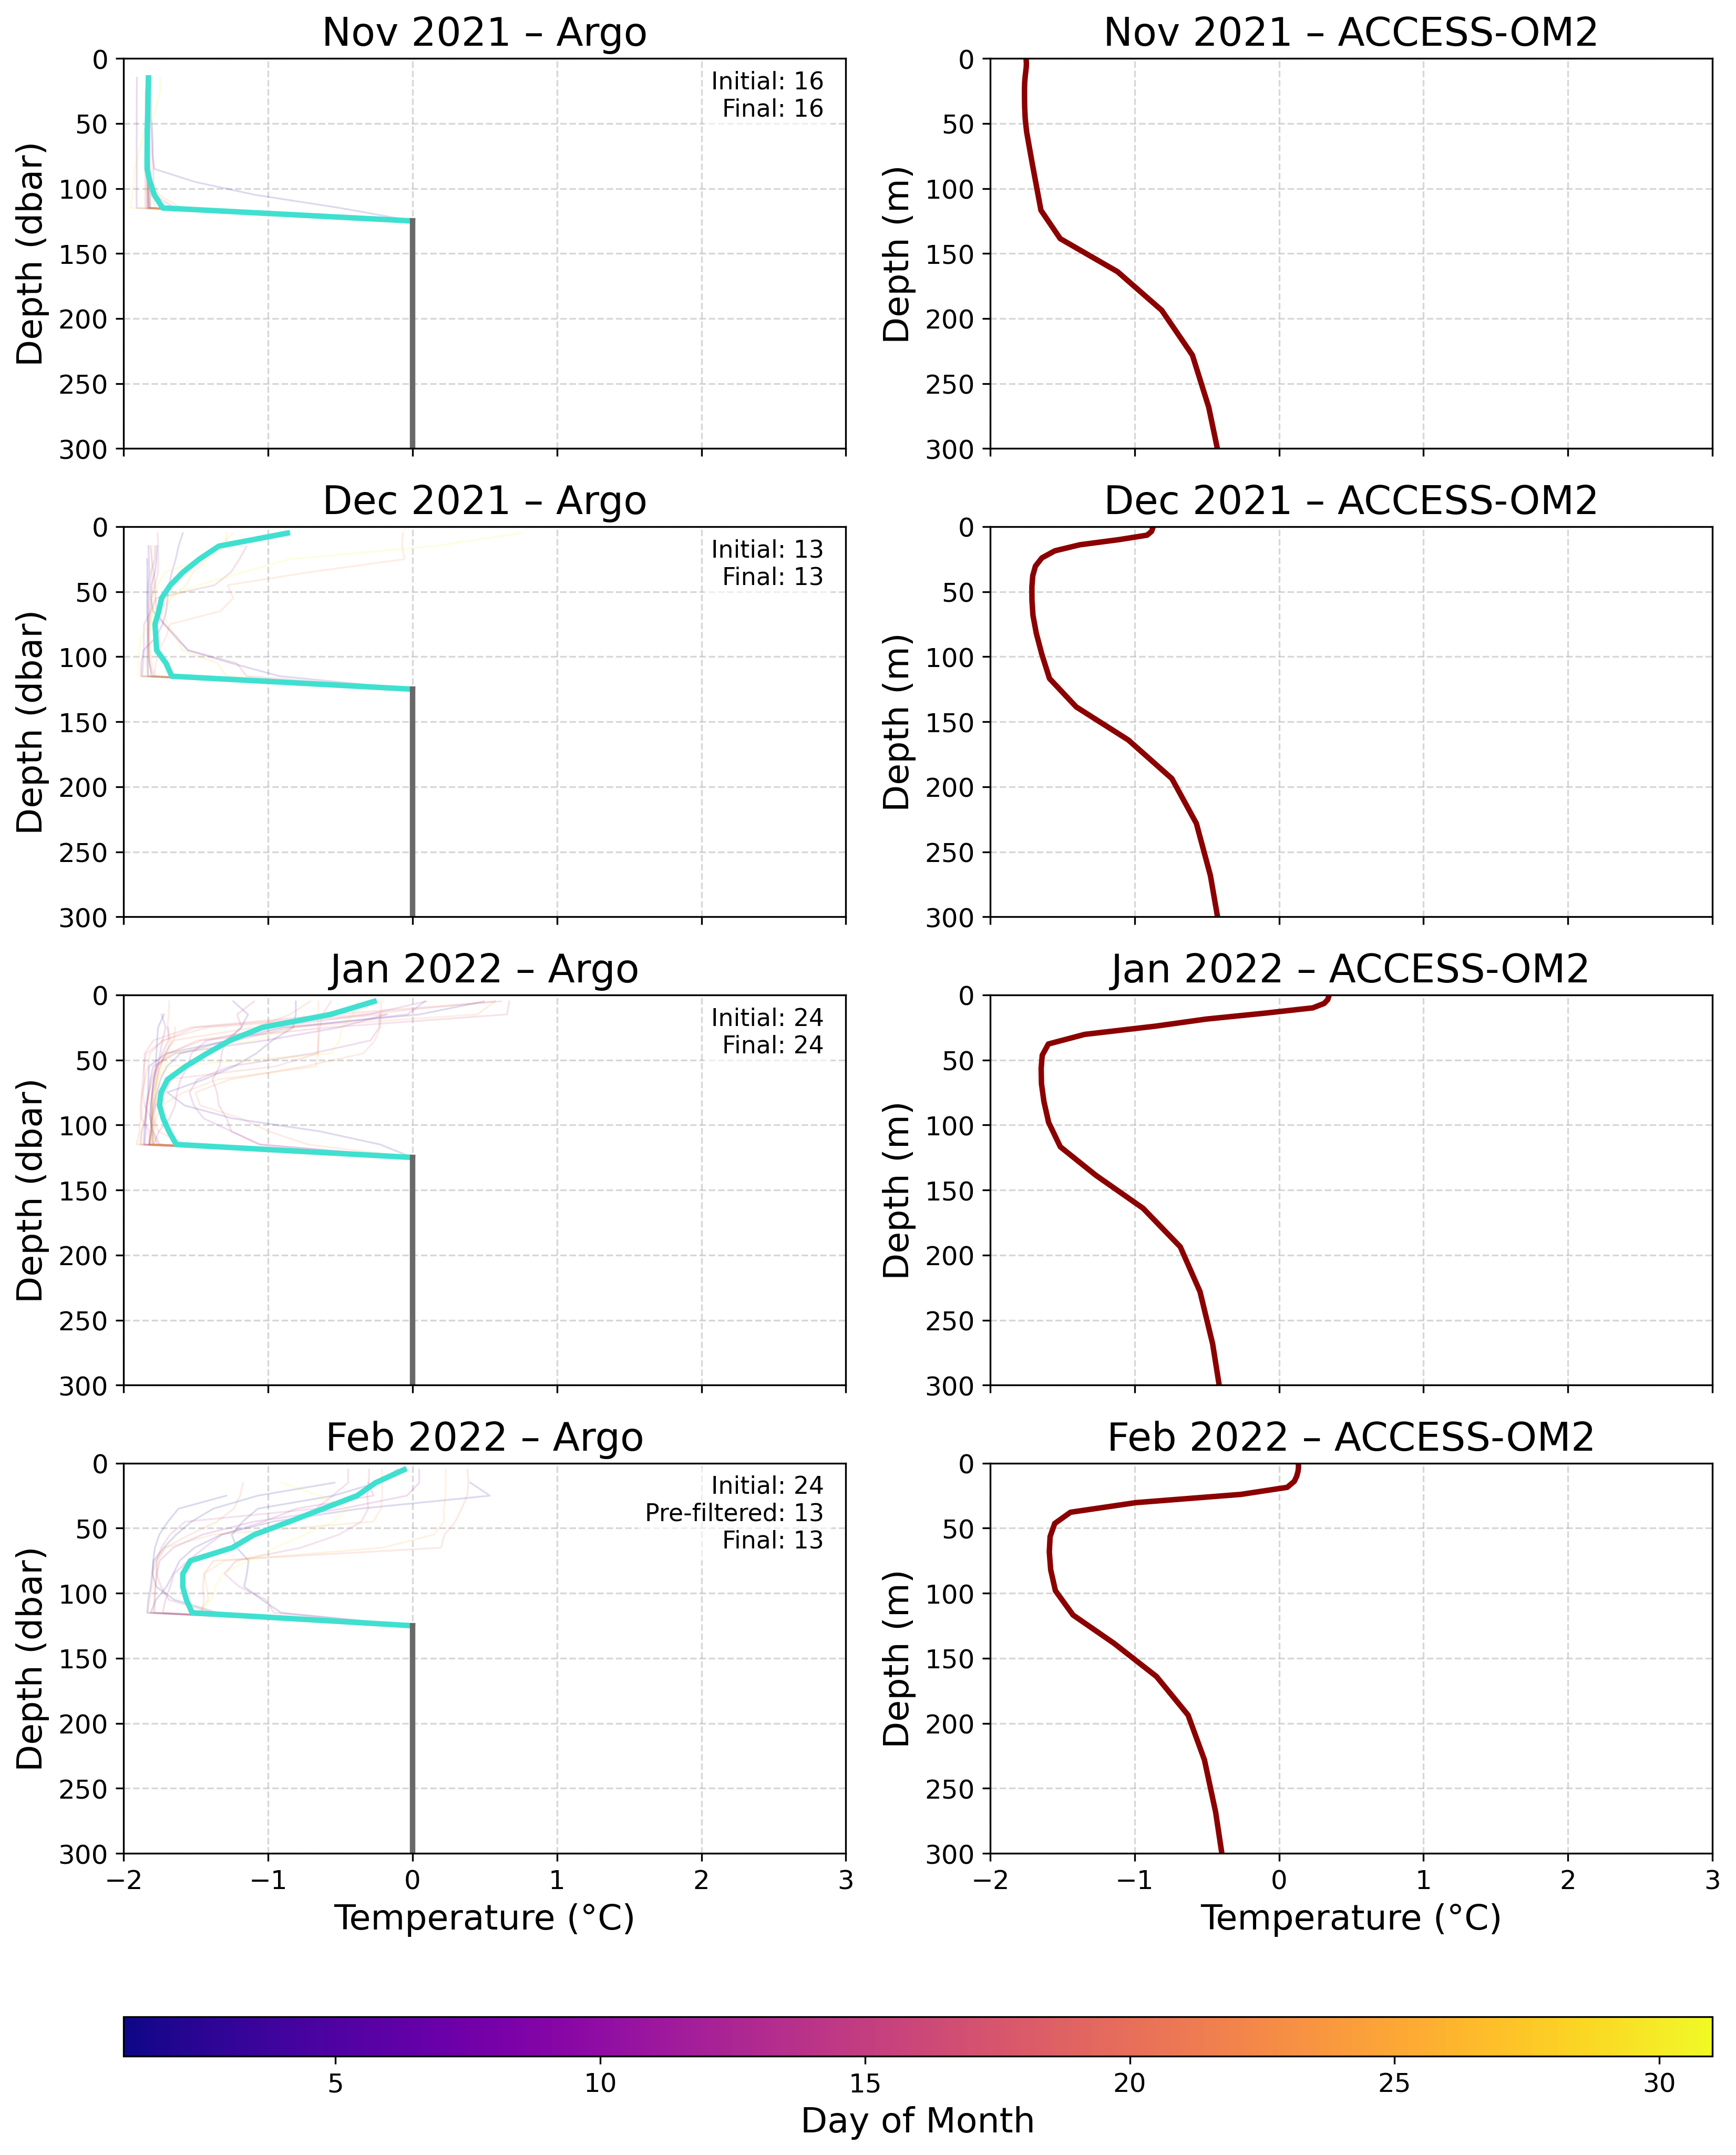

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable

# This line is only needed if you are in a Jupyter Notebook/IPython environment
%matplotlib inline

# --- Styling ---
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
})

# NOTE: The following lines assume your data variables (temp_depth, ds, sal)
# are already loaded in your environment.

# --- Months to compare ---
months = [11, 12, 1, 2]
month_names = ['Nov', 'Dec', 'Jan', 'Feb']

# --- Extract model anomalies ---
location_anom = temp_depth.sel(yt_ocean=slice(-76, -73)) \
                          .sel(xt_ocean=slice(-180, -150)) \
                          .mean(dim=['yt_ocean', 'xt_ocean']).sel(st_ocean=slice(0, 400))
time = location_anom["time"]
location_anom = location_anom.assign_coords(year=time.dt.year, month=time.dt.month)
depth_model = location_anom.st_ocean

# --- Argo data preprocessing ---
time_origin = pd.Timestamp('1950-01-01')
days = sal.dyr.values.flatten()
dates = time_origin + pd.to_timedelta(days, unit='D')

lons = sal.lon.values.flatten()
lats = sal.lat.values.flatten()
method_flags = sal.instrument_type_flag.values.flatten()

argo_mask = (method_flags == 5) & (~np.isnan(method_flags))

# Spatial box (Ross Sea)
lons_deg_east = lons % 360
in_box = (lons_deg_east >= 150) & (lons_deg_east <= 200) & (lats >= -76) & (lats <= -70)

# Depth (pressure)
pres = ds.pres[:, 0].values
pres_mask = pres <= 500

# --- Figure layout ---
fig, axes = plt.subplots(len(months), 2, figsize=(13, 4.2 * len(months)), sharex=True)

# Colors
argo_mean_color = '#40E0D0'
model_mean_color = '#8B0000'
model_faint_color = '#d3d3d3'
cmap = plt.cm.plasma
# --- NEW COLORS FOR GREYING OUT ---
deep_argo_color = 'grey'
deep_argo_mean_color = '#696969' # dimgrey

for row, (month, month_name) in enumerate(zip(months, month_names)):
    # -------- Argo (left column) --------
    ax_argo = axes[row, 0]
    target_year = 2021 if month in (11, 12) else 2022
    
    in_time = (dates.year == target_year) & (dates.month == month)
    selected = in_box & argo_mask & in_time
    indices = np.where(selected)[0]
    
    initial_count = len(indices)
    pre_filtered_count = initial_count
    n_profiles = 0

    if initial_count > 0:
        candidate_profiles_data = [ds.ct[:, idx].values[pres_mask] for idx in indices]
        candidate_days = dates[indices].day

        # --- STAGE 1: Physical Pre-filtering ---
        pre_filtered_profiles = []
        pre_filtered_days = []
        if month == 2:
            depth_75m_idx = np.argmin(np.abs(pres[pres_mask] - 75))
            for profile, day in zip(candidate_profiles_data, candidate_days):
                temp_at_75m = profile[depth_75m_idx]
                if not np.isnan(temp_at_75m) and temp_at_75m <= -1:
                    pre_filtered_profiles.append(profile)
                    pre_filtered_days.append(day)
            pre_filtered_count = len(pre_filtered_profiles)
        else:
            pre_filtered_profiles = candidate_profiles_data
            pre_filtered_days = candidate_days

        # --- STAGE 2: Statistical Outlier Removal ---
        final_profiles = []
        final_days = []
        if len(pre_filtered_profiles) > 3:
            profiles_array = np.vstack(pre_filtered_profiles)
            mean_at_depth = np.nanmean(profiles_array, axis=0)
            std_at_depth = np.nanstd(profiles_array, axis=0)
            upper_bound = mean_at_depth + 3.0 * std_at_depth
            lower_bound = mean_at_depth - 3.0 * std_at_depth
            for i, profile in enumerate(pre_filtered_profiles):
                outlier_points = np.sum(((profile < lower_bound) | (profile > upper_bound)) & ~np.isnan(profile))
                if outlier_points <= 5:
                    final_profiles.append(profile)
                    final_days.append(pre_filtered_days[i])
        else:
            final_profiles = pre_filtered_profiles
            final_days = pre_filtered_days

        # Plot the final, cleaned profiles
        if len(final_profiles) > 0:
            n_profiles = len(final_profiles)
            final_days = np.array(final_days)
            
            # --- Find the index to split the data at 120 dbar ---
            cutoff_idx = np.searchsorted(pres[pres_mask], 120)
            
            day_range = final_days.max() - final_days.min()
            norm_days = (final_days - final_days.min()) / day_range if day_range > 0 else np.full_like(final_days, 0.5, dtype=float)
            
            # --- Plot each profile in two parts ---
            for profile, n_day in zip(final_profiles, norm_days):
                ax_argo.plot(profile[:cutoff_idx+1], pres[pres_mask][:cutoff_idx+1], color=cmap(n_day), alpha=0.15, linewidth=0.8)
                ax_argo.plot(profile[cutoff_idx:], pres[pres_mask][cutoff_idx:], color=deep_argo_color, alpha=0.15, linewidth=0.8)
            
            mean_prof = np.nanmean(np.vstack(final_profiles), axis=0)
            # Plot shallow mean in color with label
            ax_argo.plot(mean_prof[:cutoff_idx+1], pres[pres_mask][:cutoff_idx+1], color=argo_mean_color, linewidth=2.5)
            # Plot deep mean in dark grey
            ax_argo.plot(mean_prof[cutoff_idx:], pres[pres_mask][cutoff_idx:], color=deep_argo_mean_color, linewidth=2.5)

    # Annotation text
    if month == 2:
        count_text = f"Initial: {initial_count}\nPre-filtered: {pre_filtered_count}\nFinal: {n_profiles}"
    else:
        count_text = f"Initial: {initial_count}\nFinal: {n_profiles}"
    ax_argo.text(0.97, 0.97, count_text,
                 transform=ax_argo.transAxes, fontsize=11,
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.6, ec='none'))

    # Axis formatting
    ax_argo.set_ylim(0, 300)
    ax_argo.invert_yaxis()
    ax_argo.set_xlim(-2, 3)
    ax_argo.set_ylabel("Depth (dbar)")
    ax_argo.set_title(f"{month_name} {target_year} – Argo")
    ax_argo.grid(True, linestyle='--', alpha=0.5)

    # -------- Model (right column) --------
    ax_model = axes[row, 1]
    mask = (location_anom.year == target_year) & (location_anom.month == month)
    profiles_model = location_anom.where(mask, drop=True)

    if profiles_model.time.size > 0:
        for i in range(profiles_model.time.size):
            ax_model.plot(profiles_model.values[i], depth_model,
                          color=model_faint_color, alpha=0.15, linewidth=0.8)
        mean_model = np.nanmean(profiles_model.values, axis=0)
        ax_model.plot(mean_model, depth_model, color=model_mean_color, linewidth=2.5)

    ax_model.set_ylim(0, 300)
    ax_model.invert_yaxis()
    ax_model.set_xlim(-2, 3)
    ax_model.set_ylabel("Depth (m)")
    ax_model.set_title(f"{month_name} {target_year} – ACCESS-OM2")
    ax_model.grid(True, linestyle='--', alpha=0.5)

# --- Shared X label ---
for ax in axes[-1, :]:
    ax.set_xlabel("Temperature (°C)")

# --- Colorbar ---
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=31))
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes, orientation='horizontal',
                    fraction=0.04, pad=0.08, aspect=40)
cbar.set_label('Day of Month')

# --- Add legend for mean on top-left panel ---
axes[0, 0].legend(frameon=False, loc='upper right')

plt.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/argo_ross_location.png', dpi=300, bbox_inches='tight')

# --- Auto-adjust layout ---
#fig.tight_layout(rect=[0, 0.05, 1, 1])

plt.show()

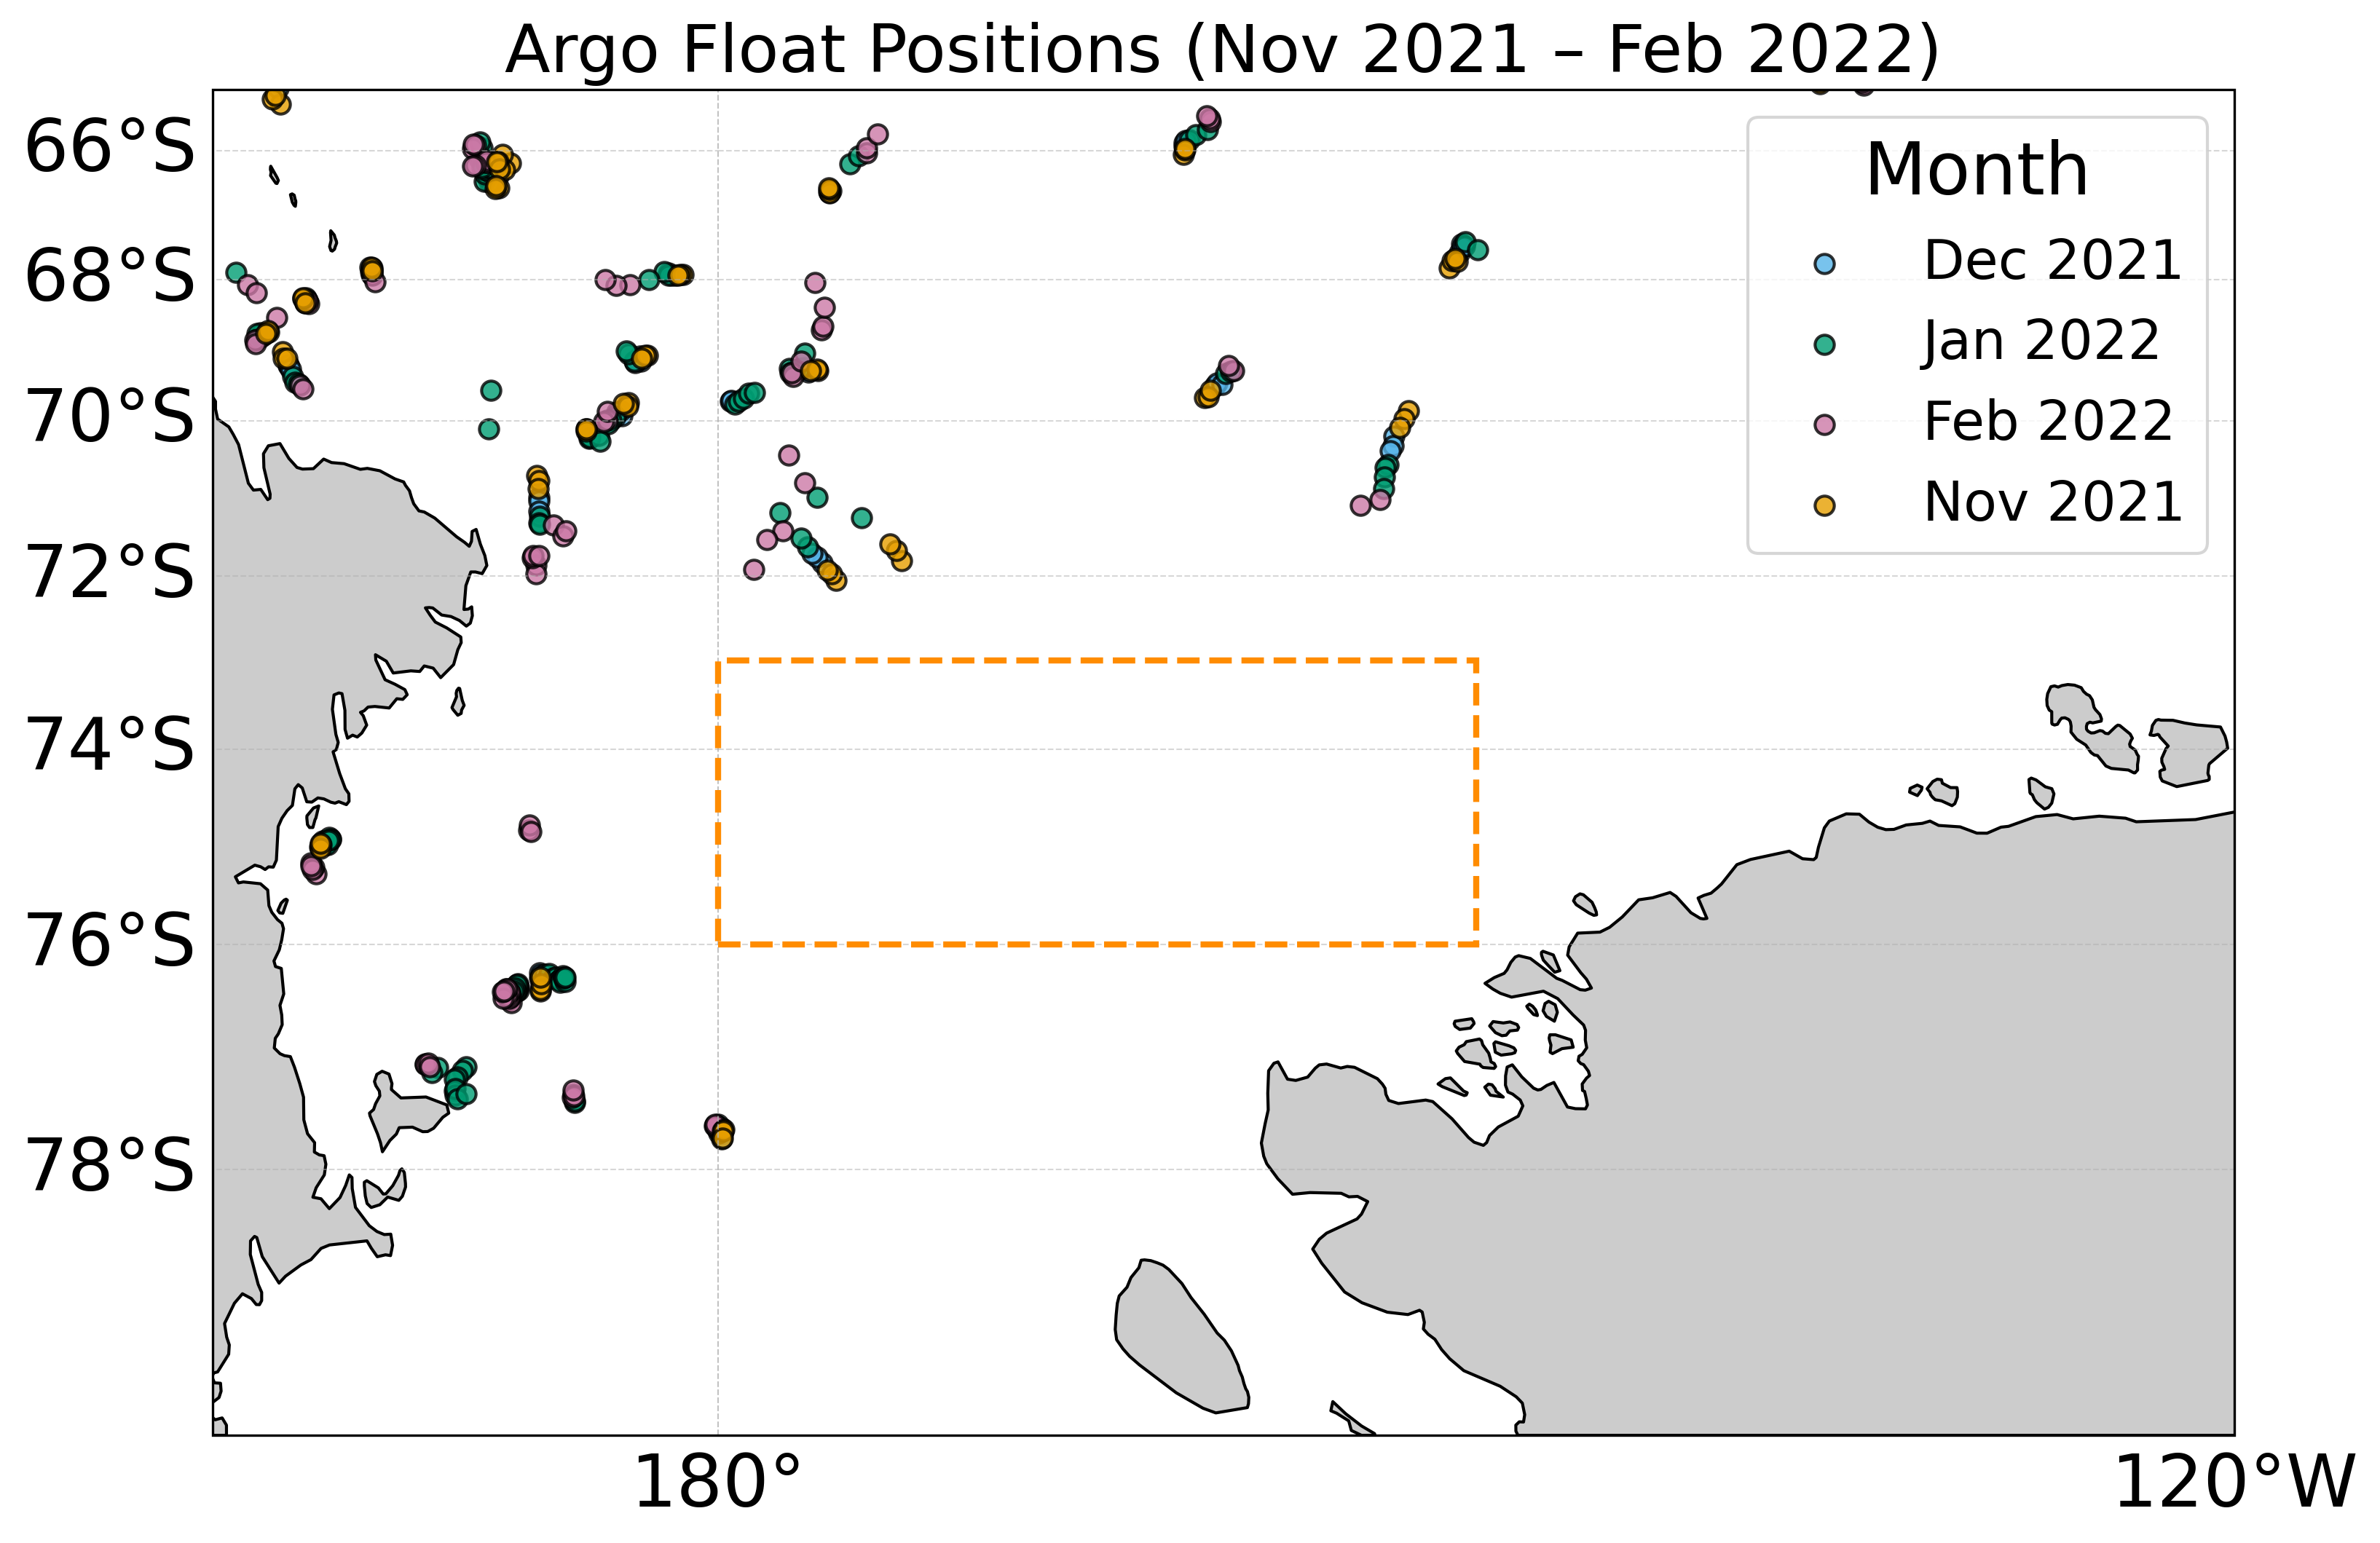

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# -------------------------
# --- Styling ---
# -------------------------
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 24,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'legend.fontsize': 18,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.dpi': 300,
})

# -------------------------
# --- Data preparation ----
# -------------------------
time_origin = pd.Timestamp('1950-01-01')
# Using 'sal' as the source for complete metadata
days = sal.dyr.values.flatten()
dates = time_origin + pd.to_timedelta(days, unit='D')

lons = sal.lon.values.flatten()
lats = sal.lat.values.flatten()
method_flags = sal.instrument_type_flag.values.flatten()

# Normalize longitudes to -180 to 180 range
lons_norm = ((lons + 180) % 360) - 180

# --- Time filtering: Nov 2021 – Feb 2022 ---
time_start = pd.Timestamp('2021-11-01')
time_end   = pd.Timestamp('2022-02-28')
time_mask = (dates >= time_start) & (dates <= time_end)

# --- Mask Argo floats within time frame and type ---
argo_mask = (method_flags == 5.0) & time_mask
argo_lons = lons_norm[argo_mask]
argo_lats = lats[argo_mask]
months = dates[argo_mask].month

# Color-blind-friendly palette and labels
month_colors = {11: "#E69F00", 12: "#56B4E9", 1: "#009E73", 2: '#CC79A7'} # Replaced grey with pink for visibility
month_labels = {11: "Nov 2021", 12: "Dec 2021", 1: "Jan 2022", 2: "Feb 2022"}

# -------------------------
# --- Plotting -------------
# -------------------------
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=180))

# Corrected map extent (160E to 120W)
extent = [160, 240, -81, -65]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Land and coastlines
land = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='0.8')
ax.add_feature(land)
ax.coastlines(resolution='50m', linewidth=0.5)

# Gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {} # Inherit size from rcParams
gl.ylabel_style = {} # Inherit size from rcParams

# Define a specific plot order to draw November last
plot_order = [12, 1, 2, 11]

jitter_degree = 0.05
for month in plot_order:
    color = month_colors[month]
    label = month_labels[month]
    mask = (months == month)
    
    # Add jitter to prevent overplotting
    jittered_lons = argo_lons[mask] + np.random.uniform(-jitter_degree, jitter_degree, size=mask.sum())
    jittered_lats = argo_lats[mask] + np.random.uniform(-jitter_degree, jitter_degree, size=mask.sum())
    
    ax.scatter(jittered_lons, jittered_lats,
               color=color, s=40, edgecolor='k', alpha=0.8,
               transform=ccrs.PlateCarree(),
               label=label)

# --- Add a box matching the analysis script ---
box_lon_min, box_lon_max = -180, -150
box_lat_min, box_lat_max = -76, -73
region_box = mpatches.Rectangle(
    (box_lon_min, box_lat_min),
    box_lon_max - box_lon_min,
    box_lat_max - box_lat_min,
    linewidth=2, edgecolor='darkorange',
    linestyle='--', facecolor='none',
    transform=ccrs.PlateCarree(), zorder=10
)
ax.add_patch(region_box)

# Title and legend (font sizes inherited from rcParams)
ax.set_title("Argo Float Positions (Nov 2021 – Feb 2022)")
ax.legend(frameon=True, loc='upper right', title="Month")

plt.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/argo_location_ross_sea_box.png', dpi=300, bbox_inches='tight')

plt.show()